In [1]:
# basics
import numpy as np
import pandas as pd
import datetime
import re

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);

np.seterr(divide = 'ignore');


In [2]:
# load data into datawrapper classes
measure_data = mc.COVID19_measures(download_data = True, measure_level = 2, only_first_dates = True, expand_measure_names = True)
jhu_data     = cdc.CoronaData(download_data = True)

In [3]:
# helper functions

def date2vector(implementdate, start = '22/1/20', end = None, shiftdays = 0):
    # generate vector of 0s and 1s when measure is implemented or not
    starttime     = datetime.datetime.strptime(start,         '%d/%m/%y')
    if end is None:
        endtime   = datetime.datetime.today()
    else:
        endtime   = datetime.datetime.strptime(end,           '%d/%m/%y')
    implementtime = datetime.datetime.strptime(implementdate, '%d/%m/%Y')
    
    totaldays   = (endtime       - starttime).days
    measuredays = (implementtime - starttime).days
    
    vec         = np.zeros(totaldays)
    vec[min(measuredays+shiftdays,len(vec)-1):] = 1
    
    return vec


def ConvertDateFormat(date):
    m,d,y = date.split('/')
    return '{:02d}/{:02d}/{:02d}'.format(int(d),int(m),int(y))



def LogCaseIncrease(df, key = 'Confirmed', mincases = None):
    cases             = np.array(df[key], dtype = np.int)
    if not mincases is None:
        restrict_date = np.argmin(cases >= mincases)
        cases         = cases[restrict_date:]
    else:
        restrict_date = 0
    ldcases           = np.log(np.diff(cases))

    return restrict_date, ldcases


def CleanUpMeasureName(measurename):
    # regression model formula can't contain special characters
    return ''.join([mn.capitalize() for mn in measurename.replace(',','').replace('-','').replace('/','').split(' ')])

In [13]:
def GetMeasureIDs(countrylist = None, measure_level = 2, mincount = None, extend_measure_names = False):
    if countrylist is None:
        countrylist = measure_data.countrylist # use ALL countries
    
    measurelist = {}
    
    # get all restrictions from countries
    for country in countrylist:
        country_measures = measure_data.CountryData(country, measure_level = 2, extend_measure_names = extend_measure_names)
        for measurename, initialdata in country_measures.items():
            if not measurename in measurelist.keys():
                measurelist[measurename] = 0
            measurelist[measurename] += 1
    
    if not mincount is None:
        # rebuild dict with restrictions
        measurelist = {k:v for k,v in measurelist.items() if v >= mincount}

    return measurelist


def SmoothTrajectories3(traj):
    if len(traj) > 3:
        newtraj       = np.zeros(len(traj))
        newtraj[0]    = (             2 * traj[0]    + traj[1] )/3.
        newtraj[1:-1] = (traj[0:-2] + 2 * traj[1:-1] + traj[2:])/4.
        newtraj[-1]   = (traj[-2]   + 2 * traj[-1]             )/3.
        return newtraj
    else:
        return traj

def SmoothTrajectories5(traj):
    if len(traj) > 5:
        newtraj       = np.zeros(len(traj))
        newtraj[0]    = (                              3 * traj[0]    + 2 * traj[1]    + traj[2]   )/6.
        newtraj[1]    = (             2 * traj[0]    + 3 * traj[1]    + 2 * traj[2]    + traj[3]   )/8.
        newtraj[2:-3] = (traj[0:-5] + 2 * traj[1:-4] + 3 * traj[2:-3] + 2 * traj[3:-2] + traj[4:-1])/9.
        newtraj[-2]   = (traj[-4]   + 2 * traj[-3]   + 3 * traj[-2]   + 2 * traj[-1]               )/8.
        newtraj[-1]   = (traj[-3]   + 2 * traj[-2]   + 3 * traj[-1]                                )/6.
        return newtraj
    else:
        return SmoothTrajectories3(traj)
    

def GetCountryTrajectories(countrylist = None, data = 'Confirmed', startcases = None, maxlen = None, smooth = False):
    if countrylist is None:
        countrylist = jhu_data.countrylist
    
    trajectories = {}
    for country in [c for c in countrylist if c in jhu_data.countrylist]:
        ctraj = np.array(jhu_data.CountryData(country)[data], dtype = np.float)
        starttraj = 0
        if not startcases is None:
            starttraj = np.argmax(ctraj >= startcases)
            ctraj = ctraj[starttraj:]
            if not maxlen is None:
                ctraj = ctraj[:min(maxlen,len(ctraj))]
        trajectories[country] = {}
        if smooth:
            ctraj = SmoothTrajectories3(ctraj)
        trajectories[country]['traj'] = ctraj
        trajectories[country]['startdate'] = ConvertDateFormat(jhu_data.CountryData(country)['Date'][starttraj])
    
    return trajectories

        
def GetRegressionDF(countrylist = None, measure_level = 2, shiftdays = 0, verbose = False, maxlen = None, smooth = None):
    # construct pd.DataFrame used for regression
    
    # get trajectories and measure list for all countries in 'countrylist'
    trajectories         = GetCountryTrajectories(countrylist = countrylist, data = 'Confirmed', startcases = 30, maxlen = maxlen, smooth = smooth)
    measureIDs           = GetMeasureIDs(countrylist = countrylist, measure_level = 2, mincount = 5)
    cleaned_measurelist  = {CleanUpMeasureName(mn):count for mn,count in measureIDs.items()}
    regressionDF         = None
    
    if verbose:
        print(measureIDs)
    
    for country in trajectories.keys():
        if country in measure_data.countrylist:
            df_entry_dict               = {}
            df_entry_dict['Country']    = country
            
            # ********************************************
            # change observable to regress here:
            df_entry_dict['Observable'] = np.diff(np.log(trajectories[country]['traj']))
            # ********************************************
            if verbose:
                print(country,df_entry_dict['Observable'])
            if not (np.isnan(df_entry_dict['Observable']).any() or np.isinf(df_entry_dict['Observable']).any()):
                if verbose:
                    # print trajectories of individual countries for checking
                    print(country,df_entry_dict['Observable'])
                obslen                      = len(df_entry_dict['Observable'])
                df_entry_dict['Time']       = np.arange(obslen)

                for measurename in measureIDs.keys():
                    implementdate = measure_data.FindMeasure(country, measurename, measure_level)
                    if not implementdate is None:
                        vec = date2vector(implementdate = implementdate, start = trajectories[country]['startdate'], shiftdays = shiftdays)[:obslen]
                    else:
                        vec = np.zeros(obslen)
                    df_entry_dict[CleanUpMeasureName(measurename)] = vec

                if regressionDF is None:
                    regressionDF = pd.DataFrame(df_entry_dict)
                else:
                    regressionDF = regressionDF.append(pd.DataFrame(df_entry_dict))
    
    return regressionDF, cleaned_measurelist


def modelprediction(country, regrDF, fitparams):
    country_df = regrDF[regrDF['Country'] == country][:]
    pred = np.array(country_df['Intercept']) + (np.arange(len(country_df))+1) * np.array(country_df['Time'])
    for measure in fitparams.columns:
        if measure[:10] != 'C(Country)' and measure != 'Intercept' and measure != 'Time':
            pred += fitparams[measure] * np.array(country_df[measure])
    
    return pd.DataFrame({'Data' : np.array(country_df['Observable']), 'Model': pred})


def GetCountryMasks(regrDF):
    countrylist = list(regrDF['Country'].unique())
    maskdict = {}
    for country in countrylist:
        mask = list(regrDF['Country'] == country)
        maskdict[country] = mask
    return maskdict


In [16]:
maxshift = 10
regrDF_new = []
model_excludeC = []
model_singleC  = []
llres = None

for shiftdays in range(0, maxshift + 1):
    print('shiftdays = {}'.format(shiftdays))
    tmp,measurelist_new = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, maxlen = 40, smooth = True)
    regrDF_new.append(tmp)

    countrylist = tmp['Country'].unique()
    formula     = 'Observable ~ C(Country) + ' + ' + '.join(measurelist_new)
    
    model_excludeC.append(dict())
    model_singleC.append(dict())
    
    for country in countrylist:
        DF_excludeC = regrDF_new[shiftdays][regrDF_new[shiftdays]['Country'] != country]
        DF_singleC  = regrDF_new[shiftdays][regrDF_new[shiftdays]['Country'] == country]
        model_excludeC[shiftdays][country] = smf.ols(formula = formula, data = DF_excludeC, drop_cols = 'Time')
        model_singleC [shiftdays][country] = smf.ols(formula = formula, data = DF_singleC,  drop_cols = 'Time')
    


shiftdays = 0
shiftdays = 1
shiftdays = 2
shiftdays = 3
shiftdays = 4
shiftdays = 5
shiftdays = 6
shiftdays = 7
shiftdays = 8
shiftdays = 9
shiftdays = 10


In [57]:
#llres = None
for shiftdays in np.arange(maxshift + 1):
    
    print('shiftdays = {}'.format(shiftdays))
    
    for alpha in np.power(10,np.linspace(-4, -2, num = 9)):
        #print('  {:.6f}'.format(alpha))
        if len(llres[(llres['shiftdays'] == shiftdays) & (llres['alpha'] == alpha)]) == 0:
            print(shiftdays,alpha,'compute')
            for country in countrylist:
                results = model_excludeC[shiftdays][country].fit_regularized(alpha = alpha, L1_wt = 1)

                param_excludeC = np.array(results.params)
                param_singleC  = np.concatenate([np.array([param_excludeC[0]]),param_excludeC[len(countrylist)-1:]])

                tmp_res = {'shiftdays': shiftdays, 'alpha': alpha, 'country' : country, 'loglike': model_singleC[shiftdays][country].loglike(param_singleC)}
                if llres is None:
                    llres = pd.DataFrame({k:np.array([v]) for k,v in tmp_res.items()})
                else:
                    llres = llres.append(tmp_res, ignore_index = True)

                    print('    ',tmp_res)
        else:
            print(shiftdays,alpha, 'already found')

shiftdays = 0
0 0.0001 already found
0 0.00017782794100389227 compute
     {'shiftdays': 0, 'alpha': 0.00017782794100389227, 'country': 'Albania', 'loglike': 40.397335094865994}
     {'shiftdays': 0, 'alpha': 0.00017782794100389227, 'country': 'Austria', 'loglike': 30.322204238509123}
     {'shiftdays': 0, 'alpha': 0.00017782794100389227, 'country': 'Belgium', 'loglike': 28.878649408812073}
     {'shiftdays': 0, 'alpha': 0.00017782794100389227, 'country': 'Bosnia and Herzegovina', 'loglike': 22.1380460452389}
     {'shiftdays': 0, 'alpha': 0.00017782794100389227, 'country': 'Canada', 'loglike': 38.197468800265014}
     {'shiftdays': 0, 'alpha': 0.00017782794100389227, 'country': 'Croatia', 'loglike': 33.09811192978064}
     {'shiftdays': 0, 'alpha': 0.00017782794100389227, 'country': 'Denmark', 'loglike': 11.219571311261266}
     {'shiftdays': 0, 'alpha': 0.00017782794100389227, 'country': 'Diamond Princess', 'loglike': 14.218550722417689}
     {'shiftdays': 0, 'alpha': 0.0001778279410

     {'shiftdays': 0, 'alpha': 0.00031622776601683794, 'country': 'United Kingdom', 'loglike': 44.60274742722193}
     {'shiftdays': 0, 'alpha': 0.00031622776601683794, 'country': 'New Zealand', 'loglike': 15.15532715512526}
     {'shiftdays': 0, 'alpha': 0.00031622776601683794, 'country': 'Japan', 'loglike': 48.0351056570384}
     {'shiftdays': 0, 'alpha': 0.00031622776601683794, 'country': 'Honduras', 'loglike': 20.130174813046978}
     {'shiftdays': 0, 'alpha': 0.00031622776601683794, 'country': 'Kazakhstan', 'loglike': 21.71915800614528}
     {'shiftdays': 0, 'alpha': 0.00031622776601683794, 'country': 'Greece', 'loglike': 40.97613293870561}
     {'shiftdays': 0, 'alpha': 0.00031622776601683794, 'country': 'North Macedonia', 'loglike': 18.793918726948505}
     {'shiftdays': 0, 'alpha': 0.00031622776601683794, 'country': 'Kosovo', 'loglike': 23.500186261289294}
     {'shiftdays': 0, 'alpha': 0.00031622776601683794, 'country': 'Brazil', 'loglike': 15.438345452225782}
     {'shiftdays

     {'shiftdays': 0, 'alpha': 0.0017782794100389228, 'country': 'Norway', 'loglike': 35.03631540519652}
     {'shiftdays': 0, 'alpha': 0.0017782794100389228, 'country': 'Portugal', 'loglike': 22.398214517402707}
     {'shiftdays': 0, 'alpha': 0.0017782794100389228, 'country': 'Romania', 'loglike': 31.949780596077716}
     {'shiftdays': 0, 'alpha': 0.0017782794100389228, 'country': 'Serbia', 'loglike': 36.76639395517981}
     {'shiftdays': 0, 'alpha': 0.0017782794100389228, 'country': 'Singapore', 'loglike': 19.939067878594145}
     {'shiftdays': 0, 'alpha': 0.0017782794100389228, 'country': 'Slovakia', 'loglike': 25.73525177546047}
     {'shiftdays': 0, 'alpha': 0.0017782794100389228, 'country': 'Spain', 'loglike': 16.64936579642753}
     {'shiftdays': 0, 'alpha': 0.0017782794100389228, 'country': 'Sweden', 'loglike': 36.9325871453394}
     {'shiftdays': 0, 'alpha': 0.0017782794100389228, 'country': 'Switzerland', 'loglike': 31.9785307862768}
     {'shiftdays': 0, 'alpha': 0.001778279

     {'shiftdays': 0, 'alpha': 0.005623413251903491, 'country': 'Iceland', 'loglike': 44.211467858831874}
     {'shiftdays': 0, 'alpha': 0.005623413251903491, 'country': 'Indonesia', 'loglike': 29.670489974428605}
     {'shiftdays': 0, 'alpha': 0.005623413251903491, 'country': 'Italy', 'loglike': 27.86005220476075}
     {'shiftdays': 0, 'alpha': 0.005623413251903491, 'country': 'Kuwait', 'loglike': 45.91780938983287}
     {'shiftdays': 0, 'alpha': 0.005623413251903491, 'country': 'Liechtenstein', 'loglike': 18.31661384071579}
     {'shiftdays': 0, 'alpha': 0.005623413251903491, 'country': 'Lithuania', 'loglike': 13.560499440107936}
     {'shiftdays': 0, 'alpha': 0.005623413251903491, 'country': 'Malaysia', 'loglike': 40.5595084306905}
     {'shiftdays': 0, 'alpha': 0.005623413251903491, 'country': 'Mexico', 'loglike': 27.61684951399944}
     {'shiftdays': 0, 'alpha': 0.005623413251903491, 'country': 'Montenegro', 'loglike': 20.32874624486549}
     {'shiftdays': 0, 'alpha': 0.0056234132

     {'shiftdays': 1, 'alpha': 0.00031622776601683794, 'country': 'Austria', 'loglike': 35.31827013340061}
     {'shiftdays': 1, 'alpha': 0.00031622776601683794, 'country': 'Belgium', 'loglike': 34.06959739510737}
     {'shiftdays': 1, 'alpha': 0.00031622776601683794, 'country': 'Bosnia and Herzegovina', 'loglike': 17.778147380421714}
     {'shiftdays': 1, 'alpha': 0.00031622776601683794, 'country': 'Canada', 'loglike': 40.445221410895584}
     {'shiftdays': 1, 'alpha': 0.00031622776601683794, 'country': 'Croatia', 'loglike': 36.01877500879968}
     {'shiftdays': 1, 'alpha': 0.00031622776601683794, 'country': 'Denmark', 'loglike': 11.04880264937238}
     {'shiftdays': 1, 'alpha': 0.00031622776601683794, 'country': 'Diamond Princess', 'loglike': 15.481105503653822}
     {'shiftdays': 1, 'alpha': 0.00031622776601683794, 'country': 'Ecuador', 'loglike': 6.050088570100222}
     {'shiftdays': 1, 'alpha': 0.00031622776601683794, 'country': 'Estonia', 'loglike': 37.019193101006366}
     {'shi

     {'shiftdays': 1, 'alpha': 0.0005623413251903491, 'country': 'Japan', 'loglike': 47.27283102600521}
     {'shiftdays': 1, 'alpha': 0.0005623413251903491, 'country': 'Honduras', 'loglike': 20.741771469850868}
     {'shiftdays': 1, 'alpha': 0.0005623413251903491, 'country': 'Kazakhstan', 'loglike': 15.753328046250303}
     {'shiftdays': 1, 'alpha': 0.0005623413251903491, 'country': 'Greece', 'loglike': 43.67837656612331}
     {'shiftdays': 1, 'alpha': 0.0005623413251903491, 'country': 'North Macedonia', 'loglike': 18.572657082987703}
     {'shiftdays': 1, 'alpha': 0.0005623413251903491, 'country': 'Kosovo', 'loglike': 19.012798377209286}
     {'shiftdays': 1, 'alpha': 0.0005623413251903491, 'country': 'Brazil', 'loglike': 19.88396261018555}
     {'shiftdays': 1, 'alpha': 0.0005623413251903491, 'country': 'India', 'loglike': 26.551897492488926}
     {'shiftdays': 1, 'alpha': 0.0005623413251903491, 'country': 'Hungary', 'loglike': 31.49621064834902}
1 0.001 already found
1 0.0017782794

     {'shiftdays': 1, 'alpha': 0.0031622776601683794, 'country': 'Romania', 'loglike': 30.398678888748677}
     {'shiftdays': 1, 'alpha': 0.0031622776601683794, 'country': 'Serbia', 'loglike': 35.3614214156445}
     {'shiftdays': 1, 'alpha': 0.0031622776601683794, 'country': 'Singapore', 'loglike': 24.378121516004327}
     {'shiftdays': 1, 'alpha': 0.0031622776601683794, 'country': 'Slovakia', 'loglike': 30.87600809828902}
     {'shiftdays': 1, 'alpha': 0.0031622776601683794, 'country': 'Spain', 'loglike': 17.99682215573364}
     {'shiftdays': 1, 'alpha': 0.0031622776601683794, 'country': 'Sweden', 'loglike': 34.08946562993714}
     {'shiftdays': 1, 'alpha': 0.0031622776601683794, 'country': 'Switzerland', 'loglike': 26.47655820690253}
     {'shiftdays': 1, 'alpha': 0.0031622776601683794, 'country': 'Thailand', 'loglike': 19.823843098515454}
     {'shiftdays': 1, 'alpha': 0.0031622776601683794, 'country': 'United Kingdom', 'loglike': 40.318644615627434}
     {'shiftdays': 1, 'alpha': 0

     {'shiftdays': 2, 'alpha': 0.00017782794100389227, 'country': 'Italy', 'loglike': 39.64300863034036}
     {'shiftdays': 2, 'alpha': 0.00017782794100389227, 'country': 'Kuwait', 'loglike': 30.389350653229727}
     {'shiftdays': 2, 'alpha': 0.00017782794100389227, 'country': 'Liechtenstein', 'loglike': 16.72834038686615}
     {'shiftdays': 2, 'alpha': 0.00017782794100389227, 'country': 'Lithuania', 'loglike': 12.52927221677869}
     {'shiftdays': 2, 'alpha': 0.00017782794100389227, 'country': 'Malaysia', 'loglike': 25.03744900241128}
     {'shiftdays': 2, 'alpha': 0.00017782794100389227, 'country': 'Mexico', 'loglike': 25.097282432842704}
     {'shiftdays': 2, 'alpha': 0.00017782794100389227, 'country': 'Montenegro', 'loglike': 19.11122608696157}
     {'shiftdays': 2, 'alpha': 0.00017782794100389227, 'country': 'Netherlands', 'loglike': 26.80752400566155}
     {'shiftdays': 2, 'alpha': 0.00017782794100389227, 'country': 'Norway', 'loglike': 40.8195208945091}
     {'shiftdays': 2, 'al

     {'shiftdays': 2, 'alpha': 0.0005623413251903491, 'country': 'Bosnia and Herzegovina', 'loglike': 18.525015382684906}
     {'shiftdays': 2, 'alpha': 0.0005623413251903491, 'country': 'Canada', 'loglike': 41.59607133286421}
     {'shiftdays': 2, 'alpha': 0.0005623413251903491, 'country': 'Croatia', 'loglike': 37.833264119721406}
     {'shiftdays': 2, 'alpha': 0.0005623413251903491, 'country': 'Denmark', 'loglike': 11.246671095504713}
     {'shiftdays': 2, 'alpha': 0.0005623413251903491, 'country': 'Diamond Princess', 'loglike': 18.324903005297415}
     {'shiftdays': 2, 'alpha': 0.0005623413251903491, 'country': 'Ecuador', 'loglike': 7.747009008047094}
     {'shiftdays': 2, 'alpha': 0.0005623413251903491, 'country': 'Estonia', 'loglike': 28.63750744002239}
     {'shiftdays': 2, 'alpha': 0.0005623413251903491, 'country': 'Finland', 'loglike': 25.365252669708283}
     {'shiftdays': 2, 'alpha': 0.0005623413251903491, 'country': 'Germany', 'loglike': 46.514572618719384}
     {'shiftdays'

     {'shiftdays': 2, 'alpha': 0.0017782794100389228, 'country': 'Kazakhstan', 'loglike': 23.94606788577388}
     {'shiftdays': 2, 'alpha': 0.0017782794100389228, 'country': 'Greece', 'loglike': 44.65699109349391}
     {'shiftdays': 2, 'alpha': 0.0017782794100389228, 'country': 'North Macedonia', 'loglike': 20.55483652932913}
     {'shiftdays': 2, 'alpha': 0.0017782794100389228, 'country': 'Kosovo', 'loglike': 21.32004758535868}
     {'shiftdays': 2, 'alpha': 0.0017782794100389228, 'country': 'Brazil', 'loglike': 17.960810194132776}
     {'shiftdays': 2, 'alpha': 0.0017782794100389228, 'country': 'India', 'loglike': 42.23862827582774}
     {'shiftdays': 2, 'alpha': 0.0017782794100389228, 'country': 'Hungary', 'loglike': 42.795466293579196}
2 0.0031622776601683794 compute
     {'shiftdays': 2, 'alpha': 0.0031622776601683794, 'country': 'Albania', 'loglike': 30.574086008652984}
     {'shiftdays': 2, 'alpha': 0.0031622776601683794, 'country': 'Austria', 'loglike': 31.828122870031372}
    

     {'shiftdays': 2, 'alpha': 0.005623413251903491, 'country': 'Singapore', 'loglike': 29.01711575948798}
     {'shiftdays': 2, 'alpha': 0.005623413251903491, 'country': 'Slovakia', 'loglike': 32.809773146408105}
     {'shiftdays': 2, 'alpha': 0.005623413251903491, 'country': 'Spain', 'loglike': 20.784041579544322}
     {'shiftdays': 2, 'alpha': 0.005623413251903491, 'country': 'Sweden', 'loglike': 32.024650354111884}
     {'shiftdays': 2, 'alpha': 0.005623413251903491, 'country': 'Switzerland', 'loglike': 26.30640193066383}
     {'shiftdays': 2, 'alpha': 0.005623413251903491, 'country': 'Thailand', 'loglike': 22.571423312637307}
     {'shiftdays': 2, 'alpha': 0.005623413251903491, 'country': 'United Kingdom', 'loglike': 36.10917223325154}
     {'shiftdays': 2, 'alpha': 0.005623413251903491, 'country': 'New Zealand', 'loglike': 13.560022198321992}
     {'shiftdays': 2, 'alpha': 0.005623413251903491, 'country': 'Japan', 'loglike': 56.59123711537147}
     {'shiftdays': 2, 'alpha': 0.005

     {'shiftdays': 3, 'alpha': 0.00031622776601683794, 'country': 'Kuwait', 'loglike': 22.82032906332897}
     {'shiftdays': 3, 'alpha': 0.00031622776601683794, 'country': 'Liechtenstein', 'loglike': 9.712872292802892}
     {'shiftdays': 3, 'alpha': 0.00031622776601683794, 'country': 'Lithuania', 'loglike': 8.951467706284422}
     {'shiftdays': 3, 'alpha': 0.00031622776601683794, 'country': 'Malaysia', 'loglike': 40.58259651736594}
     {'shiftdays': 3, 'alpha': 0.00031622776601683794, 'country': 'Mexico', 'loglike': 28.51529606957304}
     {'shiftdays': 3, 'alpha': 0.00031622776601683794, 'country': 'Montenegro', 'loglike': 17.605684388929024}
     {'shiftdays': 3, 'alpha': 0.00031622776601683794, 'country': 'Netherlands', 'loglike': 37.94447678585648}
     {'shiftdays': 3, 'alpha': 0.00031622776601683794, 'country': 'Norway', 'loglike': 38.58250972352275}
     {'shiftdays': 3, 'alpha': 0.00031622776601683794, 'country': 'Portugal', 'loglike': 26.154624466339612}
     {'shiftdays': 3,

     {'shiftdays': 3, 'alpha': 0.0017782794100389228, 'country': 'Canada', 'loglike': 37.88416604232161}
     {'shiftdays': 3, 'alpha': 0.0017782794100389228, 'country': 'Croatia', 'loglike': 39.892384170000966}
     {'shiftdays': 3, 'alpha': 0.0017782794100389228, 'country': 'Denmark', 'loglike': 9.071555438379622}
     {'shiftdays': 3, 'alpha': 0.0017782794100389228, 'country': 'Diamond Princess', 'loglike': 16.492945512889563}
     {'shiftdays': 3, 'alpha': 0.0017782794100389228, 'country': 'Ecuador', 'loglike': 8.769583965863518}
     {'shiftdays': 3, 'alpha': 0.0017782794100389228, 'country': 'Estonia', 'loglike': 29.322372859722094}
     {'shiftdays': 3, 'alpha': 0.0017782794100389228, 'country': 'Finland', 'loglike': 25.403512230908404}
     {'shiftdays': 3, 'alpha': 0.0017782794100389228, 'country': 'Germany', 'loglike': 37.46638471812334}
     {'shiftdays': 3, 'alpha': 0.0017782794100389228, 'country': 'Iceland', 'loglike': 46.027201656882504}
     {'shiftdays': 3, 'alpha': 0.

     {'shiftdays': 3, 'alpha': 0.0031622776601683794, 'country': 'Greece', 'loglike': 42.04592787919804}
     {'shiftdays': 3, 'alpha': 0.0031622776601683794, 'country': 'North Macedonia', 'loglike': 21.805351899049967}
     {'shiftdays': 3, 'alpha': 0.0031622776601683794, 'country': 'Kosovo', 'loglike': 23.406093476027166}
     {'shiftdays': 3, 'alpha': 0.0031622776601683794, 'country': 'Brazil', 'loglike': 15.922928980699474}
     {'shiftdays': 3, 'alpha': 0.0031622776601683794, 'country': 'India', 'loglike': 40.813704759485226}
     {'shiftdays': 3, 'alpha': 0.0031622776601683794, 'country': 'Hungary', 'loglike': 38.21728050381731}
3 0.005623413251903491 compute
     {'shiftdays': 3, 'alpha': 0.005623413251903491, 'country': 'Albania', 'loglike': 45.24787633216337}
     {'shiftdays': 3, 'alpha': 0.005623413251903491, 'country': 'Austria', 'loglike': 29.10781553017548}
     {'shiftdays': 3, 'alpha': 0.005623413251903491, 'country': 'Belgium', 'loglike': 31.33969610599633}
     {'shif

     {'shiftdays': 4, 'alpha': 0.00017782794100389227, 'country': 'Slovakia', 'loglike': 24.410389715830775}
     {'shiftdays': 4, 'alpha': 0.00017782794100389227, 'country': 'Spain', 'loglike': 24.52671228928726}
     {'shiftdays': 4, 'alpha': 0.00017782794100389227, 'country': 'Sweden', 'loglike': 35.46040704800636}
     {'shiftdays': 4, 'alpha': 0.00017782794100389227, 'country': 'Switzerland', 'loglike': 23.51011383333249}
     {'shiftdays': 4, 'alpha': 0.00017782794100389227, 'country': 'Thailand', 'loglike': 13.775547045462886}
     {'shiftdays': 4, 'alpha': 0.00017782794100389227, 'country': 'United Kingdom', 'loglike': 46.14554175712446}
     {'shiftdays': 4, 'alpha': 0.00017782794100389227, 'country': 'New Zealand', 'loglike': 19.57288865971204}
     {'shiftdays': 4, 'alpha': 0.00017782794100389227, 'country': 'Japan', 'loglike': 49.871883599110234}
     {'shiftdays': 4, 'alpha': 0.00017782794100389227, 'country': 'Honduras', 'loglike': 16.377938603231414}
     {'shiftdays': 4

     {'shiftdays': 4, 'alpha': 0.0005623413251903491, 'country': 'Liechtenstein', 'loglike': 8.009988271746423}
     {'shiftdays': 4, 'alpha': 0.0005623413251903491, 'country': 'Lithuania', 'loglike': 9.232590376374166}
     {'shiftdays': 4, 'alpha': 0.0005623413251903491, 'country': 'Malaysia', 'loglike': 40.078520270948886}
     {'shiftdays': 4, 'alpha': 0.0005623413251903491, 'country': 'Mexico', 'loglike': 27.94491190745002}
     {'shiftdays': 4, 'alpha': 0.0005623413251903491, 'country': 'Montenegro', 'loglike': 15.707163069379359}
     {'shiftdays': 4, 'alpha': 0.0005623413251903491, 'country': 'Netherlands', 'loglike': 37.60978991499107}
     {'shiftdays': 4, 'alpha': 0.0005623413251903491, 'country': 'Norway', 'loglike': 33.02018167752357}
     {'shiftdays': 4, 'alpha': 0.0005623413251903491, 'country': 'Portugal', 'loglike': 23.542507870554218}
     {'shiftdays': 4, 'alpha': 0.0005623413251903491, 'country': 'Romania', 'loglike': 36.78378550815627}
     {'shiftdays': 4, 'alpha

     {'shiftdays': 4, 'alpha': 0.0031622776601683794, 'country': 'Denmark', 'loglike': 8.32098311270867}
     {'shiftdays': 4, 'alpha': 0.0031622776601683794, 'country': 'Diamond Princess', 'loglike': 20.642994643090077}
     {'shiftdays': 4, 'alpha': 0.0031622776601683794, 'country': 'Ecuador', 'loglike': 5.611709276672663}
     {'shiftdays': 4, 'alpha': 0.0031622776601683794, 'country': 'Estonia', 'loglike': 30.4263977310746}
     {'shiftdays': 4, 'alpha': 0.0031622776601683794, 'country': 'Finland', 'loglike': 23.944974241353066}
     {'shiftdays': 4, 'alpha': 0.0031622776601683794, 'country': 'Germany', 'loglike': 32.92489344299574}
     {'shiftdays': 4, 'alpha': 0.0031622776601683794, 'country': 'Iceland', 'loglike': 47.100634863795044}
     {'shiftdays': 4, 'alpha': 0.0031622776601683794, 'country': 'Indonesia', 'loglike': 32.52313444075821}
     {'shiftdays': 4, 'alpha': 0.0031622776601683794, 'country': 'Italy', 'loglike': 30.15665373740312}
     {'shiftdays': 4, 'alpha': 0.003

     {'shiftdays': 4, 'alpha': 0.005623413251903491, 'country': 'Brazil', 'loglike': 11.991323456815067}
     {'shiftdays': 4, 'alpha': 0.005623413251903491, 'country': 'India', 'loglike': 42.866419425796316}
     {'shiftdays': 4, 'alpha': 0.005623413251903491, 'country': 'Hungary', 'loglike': 36.661766722449556}
4 0.01 already found
shiftdays = 5
5 0.0001 already found
5 0.00017782794100389227 compute
     {'shiftdays': 5, 'alpha': 0.00017782794100389227, 'country': 'Albania', 'loglike': 37.73127428603122}
     {'shiftdays': 5, 'alpha': 0.00017782794100389227, 'country': 'Austria', 'loglike': 30.702579868507264}
     {'shiftdays': 5, 'alpha': 0.00017782794100389227, 'country': 'Belgium', 'loglike': 37.08667303400909}
     {'shiftdays': 5, 'alpha': 0.00017782794100389227, 'country': 'Bosnia and Herzegovina', 'loglike': 29.46293021003175}
     {'shiftdays': 5, 'alpha': 0.00017782794100389227, 'country': 'Canada', 'loglike': 28.57366297461016}
     {'shiftdays': 5, 'alpha': 0.00017782794

     {'shiftdays': 5, 'alpha': 0.00031622776601683794, 'country': 'Sweden', 'loglike': 31.015744724220028}
     {'shiftdays': 5, 'alpha': 0.00031622776601683794, 'country': 'Switzerland', 'loglike': 29.138512447130786}
     {'shiftdays': 5, 'alpha': 0.00031622776601683794, 'country': 'Thailand', 'loglike': 9.009802700209747}
     {'shiftdays': 5, 'alpha': 0.00031622776601683794, 'country': 'United Kingdom', 'loglike': 45.91915584865909}
     {'shiftdays': 5, 'alpha': 0.00031622776601683794, 'country': 'New Zealand', 'loglike': 17.373730516560716}
     {'shiftdays': 5, 'alpha': 0.00031622776601683794, 'country': 'Japan', 'loglike': 49.74372109736028}
     {'shiftdays': 5, 'alpha': 0.00031622776601683794, 'country': 'Honduras', 'loglike': 19.289890517123403}
     {'shiftdays': 5, 'alpha': 0.00031622776601683794, 'country': 'Kazakhstan', 'loglike': 20.32067842101432}
     {'shiftdays': 5, 'alpha': 0.00031622776601683794, 'country': 'Greece', 'loglike': 34.50701624670611}
     {'shiftdays'

     {'shiftdays': 5, 'alpha': 0.0017782794100389228, 'country': 'Mexico', 'loglike': 27.878265936425663}
     {'shiftdays': 5, 'alpha': 0.0017782794100389228, 'country': 'Montenegro', 'loglike': 16.39274217744624}
     {'shiftdays': 5, 'alpha': 0.0017782794100389228, 'country': 'Netherlands', 'loglike': 36.93857147360498}
     {'shiftdays': 5, 'alpha': 0.0017782794100389228, 'country': 'Norway', 'loglike': 34.6369793869147}
     {'shiftdays': 5, 'alpha': 0.0017782794100389228, 'country': 'Portugal', 'loglike': 19.8324740706518}
     {'shiftdays': 5, 'alpha': 0.0017782794100389228, 'country': 'Romania', 'loglike': 32.71391301310818}
     {'shiftdays': 5, 'alpha': 0.0017782794100389228, 'country': 'Serbia', 'loglike': 27.082512732836364}
     {'shiftdays': 5, 'alpha': 0.0017782794100389228, 'country': 'Singapore', 'loglike': 36.60268013699293}
     {'shiftdays': 5, 'alpha': 0.0017782794100389228, 'country': 'Slovakia', 'loglike': 35.99807615819769}
     {'shiftdays': 5, 'alpha': 0.00177

     {'shiftdays': 5, 'alpha': 0.005623413251903491, 'country': 'Estonia', 'loglike': 29.65492717798341}
     {'shiftdays': 5, 'alpha': 0.005623413251903491, 'country': 'Finland', 'loglike': 22.749377425309746}
     {'shiftdays': 5, 'alpha': 0.005623413251903491, 'country': 'Germany', 'loglike': 29.83863867828235}
     {'shiftdays': 5, 'alpha': 0.005623413251903491, 'country': 'Iceland', 'loglike': 44.1935244756634}
     {'shiftdays': 5, 'alpha': 0.005623413251903491, 'country': 'Indonesia', 'loglike': 27.438071833592403}
     {'shiftdays': 5, 'alpha': 0.005623413251903491, 'country': 'Italy', 'loglike': 31.331067494432062}
     {'shiftdays': 5, 'alpha': 0.005623413251903491, 'country': 'Kuwait', 'loglike': 42.364481790657535}
     {'shiftdays': 5, 'alpha': 0.005623413251903491, 'country': 'Liechtenstein', 'loglike': 14.757047630880159}
     {'shiftdays': 5, 'alpha': 0.005623413251903491, 'country': 'Lithuania', 'loglike': 12.721129176466302}
     {'shiftdays': 5, 'alpha': 0.0056234132

     {'shiftdays': 6, 'alpha': 0.00017782794100389227, 'country': 'Hungary', 'loglike': 30.783932977525026}
6 0.00031622776601683794 compute
     {'shiftdays': 6, 'alpha': 0.00031622776601683794, 'country': 'Albania', 'loglike': 35.10030505503234}
     {'shiftdays': 6, 'alpha': 0.00031622776601683794, 'country': 'Austria', 'loglike': 25.85935995975057}
     {'shiftdays': 6, 'alpha': 0.00031622776601683794, 'country': 'Belgium', 'loglike': 39.51770317454321}
     {'shiftdays': 6, 'alpha': 0.00031622776601683794, 'country': 'Bosnia and Herzegovina', 'loglike': 33.11437821671758}
     {'shiftdays': 6, 'alpha': 0.00031622776601683794, 'country': 'Canada', 'loglike': 38.64030049152048}
     {'shiftdays': 6, 'alpha': 0.00031622776601683794, 'country': 'Croatia', 'loglike': 30.385801805733934}
     {'shiftdays': 6, 'alpha': 0.00031622776601683794, 'country': 'Denmark', 'loglike': 11.096862543774197}
     {'shiftdays': 6, 'alpha': 0.00031622776601683794, 'country': 'Diamond Princess', 'loglike

     {'shiftdays': 6, 'alpha': 0.0005623413251903491, 'country': 'United Kingdom', 'loglike': 47.323151080631646}
     {'shiftdays': 6, 'alpha': 0.0005623413251903491, 'country': 'New Zealand', 'loglike': 22.494000020376898}
     {'shiftdays': 6, 'alpha': 0.0005623413251903491, 'country': 'Japan', 'loglike': 45.04211121044651}
     {'shiftdays': 6, 'alpha': 0.0005623413251903491, 'country': 'Honduras', 'loglike': 17.742755628300095}
     {'shiftdays': 6, 'alpha': 0.0005623413251903491, 'country': 'Kazakhstan', 'loglike': 19.959324647809318}
     {'shiftdays': 6, 'alpha': 0.0005623413251903491, 'country': 'Greece', 'loglike': 33.85081581767218}
     {'shiftdays': 6, 'alpha': 0.0005623413251903491, 'country': 'North Macedonia', 'loglike': 22.687750008865493}
     {'shiftdays': 6, 'alpha': 0.0005623413251903491, 'country': 'Kosovo', 'loglike': 12.977246667738413}
     {'shiftdays': 6, 'alpha': 0.0005623413251903491, 'country': 'Brazil', 'loglike': 17.18789488200843}
     {'shiftdays': 6, 

     {'shiftdays': 6, 'alpha': 0.0031622776601683794, 'country': 'Norway', 'loglike': 32.67939445615487}
     {'shiftdays': 6, 'alpha': 0.0031622776601683794, 'country': 'Portugal', 'loglike': 20.125026529027636}
     {'shiftdays': 6, 'alpha': 0.0031622776601683794, 'country': 'Romania', 'loglike': 31.152940276494178}
     {'shiftdays': 6, 'alpha': 0.0031622776601683794, 'country': 'Serbia', 'loglike': 35.30825898816205}
     {'shiftdays': 6, 'alpha': 0.0031622776601683794, 'country': 'Singapore', 'loglike': 48.97446300978751}
     {'shiftdays': 6, 'alpha': 0.0031622776601683794, 'country': 'Slovakia', 'loglike': 33.54338880795956}
     {'shiftdays': 6, 'alpha': 0.0031622776601683794, 'country': 'Spain', 'loglike': 29.646238979767816}
     {'shiftdays': 6, 'alpha': 0.0031622776601683794, 'country': 'Sweden', 'loglike': 36.99781059866018}
     {'shiftdays': 6, 'alpha': 0.0031622776601683794, 'country': 'Switzerland', 'loglike': 29.860391705744426}
     {'shiftdays': 6, 'alpha': 0.003162

     {'shiftdays': 7, 'alpha': 0.00017782794100389227, 'country': 'Iceland', 'loglike': 36.96688787724087}
     {'shiftdays': 7, 'alpha': 0.00017782794100389227, 'country': 'Indonesia', 'loglike': 28.335310254843463}
     {'shiftdays': 7, 'alpha': 0.00017782794100389227, 'country': 'Italy', 'loglike': 42.85642872353968}
     {'shiftdays': 7, 'alpha': 0.00017782794100389227, 'country': 'Kuwait', 'loglike': 19.34944286455884}
     {'shiftdays': 7, 'alpha': 0.00017782794100389227, 'country': 'Liechtenstein', 'loglike': 9.679363148874799}
     {'shiftdays': 7, 'alpha': 0.00017782794100389227, 'country': 'Lithuania', 'loglike': 13.160104415728785}
     {'shiftdays': 7, 'alpha': 0.00017782794100389227, 'country': 'Malaysia', 'loglike': 27.399172214394085}
     {'shiftdays': 7, 'alpha': 0.00017782794100389227, 'country': 'Mexico', 'loglike': 34.411137599120266}
     {'shiftdays': 7, 'alpha': 0.00017782794100389227, 'country': 'Montenegro', 'loglike': 19.44254932993906}
     {'shiftdays': 7, '

     {'shiftdays': 7, 'alpha': 0.0005623413251903491, 'country': 'Austria', 'loglike': 37.46689891535116}
     {'shiftdays': 7, 'alpha': 0.0005623413251903491, 'country': 'Belgium', 'loglike': 37.76705979685165}
     {'shiftdays': 7, 'alpha': 0.0005623413251903491, 'country': 'Bosnia and Herzegovina', 'loglike': 33.101683991346555}
     {'shiftdays': 7, 'alpha': 0.0005623413251903491, 'country': 'Canada', 'loglike': 43.97588596082049}
     {'shiftdays': 7, 'alpha': 0.0005623413251903491, 'country': 'Croatia', 'loglike': 35.136265766333366}
     {'shiftdays': 7, 'alpha': 0.0005623413251903491, 'country': 'Denmark', 'loglike': 10.816874416686755}
     {'shiftdays': 7, 'alpha': 0.0005623413251903491, 'country': 'Diamond Princess', 'loglike': 11.494620989580113}
     {'shiftdays': 7, 'alpha': 0.0005623413251903491, 'country': 'Ecuador', 'loglike': 9.779191061329989}
     {'shiftdays': 7, 'alpha': 0.0005623413251903491, 'country': 'Estonia', 'loglike': 24.63571807673563}
     {'shiftdays': 

     {'shiftdays': 7, 'alpha': 0.0017782794100389228, 'country': 'Japan', 'loglike': 31.844375042095706}
     {'shiftdays': 7, 'alpha': 0.0017782794100389228, 'country': 'Honduras', 'loglike': 17.018851598075074}
     {'shiftdays': 7, 'alpha': 0.0017782794100389228, 'country': 'Kazakhstan', 'loglike': 20.33867403037725}
     {'shiftdays': 7, 'alpha': 0.0017782794100389228, 'country': 'Greece', 'loglike': 41.8723539869876}
     {'shiftdays': 7, 'alpha': 0.0017782794100389228, 'country': 'North Macedonia', 'loglike': 24.169860944476454}
     {'shiftdays': 7, 'alpha': 0.0017782794100389228, 'country': 'Kosovo', 'loglike': 15.262917731734284}
     {'shiftdays': 7, 'alpha': 0.0017782794100389228, 'country': 'Brazil', 'loglike': 16.683021862846772}
     {'shiftdays': 7, 'alpha': 0.0017782794100389228, 'country': 'India', 'loglike': 32.03250598525796}
     {'shiftdays': 7, 'alpha': 0.0017782794100389228, 'country': 'Hungary', 'loglike': 37.49396263963445}
7 0.0031622776601683794 compute
     

     {'shiftdays': 7, 'alpha': 0.005623413251903491, 'country': 'Romania', 'loglike': 24.998076279064406}
     {'shiftdays': 7, 'alpha': 0.005623413251903491, 'country': 'Serbia', 'loglike': 35.31528147746832}
     {'shiftdays': 7, 'alpha': 0.005623413251903491, 'country': 'Singapore', 'loglike': 38.49064026044361}
     {'shiftdays': 7, 'alpha': 0.005623413251903491, 'country': 'Slovakia', 'loglike': 31.564115550800267}
     {'shiftdays': 7, 'alpha': 0.005623413251903491, 'country': 'Spain', 'loglike': 24.41469771284288}
     {'shiftdays': 7, 'alpha': 0.005623413251903491, 'country': 'Sweden', 'loglike': 35.86683471186272}
     {'shiftdays': 7, 'alpha': 0.005623413251903491, 'country': 'Switzerland', 'loglike': 28.8015044196898}
     {'shiftdays': 7, 'alpha': 0.005623413251903491, 'country': 'Thailand', 'loglike': 18.422450056263145}
     {'shiftdays': 7, 'alpha': 0.005623413251903491, 'country': 'United Kingdom', 'loglike': 39.25944671185496}
     {'shiftdays': 7, 'alpha': 0.005623413

     {'shiftdays': 8, 'alpha': 0.00031622776601683794, 'country': 'Indonesia', 'loglike': 28.759840101511784}
     {'shiftdays': 8, 'alpha': 0.00031622776601683794, 'country': 'Italy', 'loglike': 42.62039234484365}
     {'shiftdays': 8, 'alpha': 0.00031622776601683794, 'country': 'Kuwait', 'loglike': 32.437941909490334}
     {'shiftdays': 8, 'alpha': 0.00031622776601683794, 'country': 'Liechtenstein', 'loglike': 7.000492350245102}
     {'shiftdays': 8, 'alpha': 0.00031622776601683794, 'country': 'Lithuania', 'loglike': 16.575343192941585}
     {'shiftdays': 8, 'alpha': 0.00031622776601683794, 'country': 'Malaysia', 'loglike': 36.816769302580184}
     {'shiftdays': 8, 'alpha': 0.00031622776601683794, 'country': 'Mexico', 'loglike': 40.94711473182372}
     {'shiftdays': 8, 'alpha': 0.00031622776601683794, 'country': 'Montenegro', 'loglike': 16.645406566009708}
     {'shiftdays': 8, 'alpha': 0.00031622776601683794, 'country': 'Netherlands', 'loglike': 40.26755383456964}
     {'shiftdays':

     {'shiftdays': 8, 'alpha': 0.0017782794100389228, 'country': 'Belgium', 'loglike': 36.56144759218379}
     {'shiftdays': 8, 'alpha': 0.0017782794100389228, 'country': 'Bosnia and Herzegovina', 'loglike': 33.570986115801404}
     {'shiftdays': 8, 'alpha': 0.0017782794100389228, 'country': 'Canada', 'loglike': 45.078181215569785}
     {'shiftdays': 8, 'alpha': 0.0017782794100389228, 'country': 'Croatia', 'loglike': 34.25711927991766}
     {'shiftdays': 8, 'alpha': 0.0017782794100389228, 'country': 'Denmark', 'loglike': 10.30031153368844}
     {'shiftdays': 8, 'alpha': 0.0017782794100389228, 'country': 'Diamond Princess', 'loglike': 13.91738812871651}
     {'shiftdays': 8, 'alpha': 0.0017782794100389228, 'country': 'Ecuador', 'loglike': 10.049264172474999}
     {'shiftdays': 8, 'alpha': 0.0017782794100389228, 'country': 'Estonia', 'loglike': 25.049220869905255}
     {'shiftdays': 8, 'alpha': 0.0017782794100389228, 'country': 'Finland', 'loglike': 25.78614649551936}
     {'shiftdays': 

     {'shiftdays': 8, 'alpha': 0.0031622776601683794, 'country': 'Honduras', 'loglike': 17.13488097743823}
     {'shiftdays': 8, 'alpha': 0.0031622776601683794, 'country': 'Kazakhstan', 'loglike': 21.393312698513952}
     {'shiftdays': 8, 'alpha': 0.0031622776601683794, 'country': 'Greece', 'loglike': 43.5291985317269}
     {'shiftdays': 8, 'alpha': 0.0031622776601683794, 'country': 'North Macedonia', 'loglike': 26.72176209380651}
     {'shiftdays': 8, 'alpha': 0.0031622776601683794, 'country': 'Kosovo', 'loglike': 13.15370654343453}
     {'shiftdays': 8, 'alpha': 0.0031622776601683794, 'country': 'Brazil', 'loglike': 15.351115537189948}
     {'shiftdays': 8, 'alpha': 0.0031622776601683794, 'country': 'India', 'loglike': 34.04655729008234}
     {'shiftdays': 8, 'alpha': 0.0031622776601683794, 'country': 'Hungary', 'loglike': 33.35059578116494}
8 0.005623413251903491 compute
     {'shiftdays': 8, 'alpha': 0.005623413251903491, 'country': 'Albania', 'loglike': 40.42260669175516}
     {'s

     {'shiftdays': 9, 'alpha': 0.00017782794100389227, 'country': 'Serbia', 'loglike': 30.93677920540013}
     {'shiftdays': 9, 'alpha': 0.00017782794100389227, 'country': 'Singapore', 'loglike': 36.33097953004631}
     {'shiftdays': 9, 'alpha': 0.00017782794100389227, 'country': 'Slovakia', 'loglike': 30.879419000103965}
     {'shiftdays': 9, 'alpha': 0.00017782794100389227, 'country': 'Spain', 'loglike': 24.049552218641722}
     {'shiftdays': 9, 'alpha': 0.00017782794100389227, 'country': 'Sweden', 'loglike': 39.035364043474075}
     {'shiftdays': 9, 'alpha': 0.00017782794100389227, 'country': 'Switzerland', 'loglike': 29.416433249726246}
     {'shiftdays': 9, 'alpha': 0.00017782794100389227, 'country': 'Thailand', 'loglike': 13.076120023882098}
     {'shiftdays': 9, 'alpha': 0.00017782794100389227, 'country': 'United Kingdom', 'loglike': 46.48629662837622}
     {'shiftdays': 9, 'alpha': 0.00017782794100389227, 'country': 'New Zealand', 'loglike': 20.688091137888062}
     {'shiftdays

     {'shiftdays': 9, 'alpha': 0.0005623413251903491, 'country': 'Italy', 'loglike': 41.682523673248454}
     {'shiftdays': 9, 'alpha': 0.0005623413251903491, 'country': 'Kuwait', 'loglike': 30.18489871138766}
     {'shiftdays': 9, 'alpha': 0.0005623413251903491, 'country': 'Liechtenstein', 'loglike': 6.596299767740037}
     {'shiftdays': 9, 'alpha': 0.0005623413251903491, 'country': 'Lithuania', 'loglike': 17.190962581842815}
     {'shiftdays': 9, 'alpha': 0.0005623413251903491, 'country': 'Malaysia', 'loglike': 45.39864404764225}
     {'shiftdays': 9, 'alpha': 0.0005623413251903491, 'country': 'Mexico', 'loglike': 34.87810231335442}
     {'shiftdays': 9, 'alpha': 0.0005623413251903491, 'country': 'Montenegro', 'loglike': 15.823160087387944}
     {'shiftdays': 9, 'alpha': 0.0005623413251903491, 'country': 'Netherlands', 'loglike': 40.68627674973804}
     {'shiftdays': 9, 'alpha': 0.0005623413251903491, 'country': 'Norway', 'loglike': 31.390634554134266}
     {'shiftdays': 9, 'alpha': 

     {'shiftdays': 9, 'alpha': 0.0031622776601683794, 'country': 'Canada', 'loglike': 43.96898023027006}
     {'shiftdays': 9, 'alpha': 0.0031622776601683794, 'country': 'Croatia', 'loglike': 35.516278080820584}
     {'shiftdays': 9, 'alpha': 0.0031622776601683794, 'country': 'Denmark', 'loglike': 9.41636418005395}
     {'shiftdays': 9, 'alpha': 0.0031622776601683794, 'country': 'Diamond Princess', 'loglike': 16.086479319968674}
     {'shiftdays': 9, 'alpha': 0.0031622776601683794, 'country': 'Ecuador', 'loglike': 8.502789840054035}
     {'shiftdays': 9, 'alpha': 0.0031622776601683794, 'country': 'Estonia', 'loglike': 28.4389864586651}
     {'shiftdays': 9, 'alpha': 0.0031622776601683794, 'country': 'Finland', 'loglike': 24.772082636034966}
     {'shiftdays': 9, 'alpha': 0.0031622776601683794, 'country': 'Germany', 'loglike': 35.38227753122315}
     {'shiftdays': 9, 'alpha': 0.0031622776601683794, 'country': 'Iceland', 'loglike': 42.74574108495384}
     {'shiftdays': 9, 'alpha': 0.0031

     {'shiftdays': 9, 'alpha': 0.005623413251903491, 'country': 'North Macedonia', 'loglike': 25.77460909919892}
     {'shiftdays': 9, 'alpha': 0.005623413251903491, 'country': 'Kosovo', 'loglike': 11.773923398741807}
     {'shiftdays': 9, 'alpha': 0.005623413251903491, 'country': 'Brazil', 'loglike': 14.746850553128738}
     {'shiftdays': 9, 'alpha': 0.005623413251903491, 'country': 'India', 'loglike': 39.185220746933815}
     {'shiftdays': 9, 'alpha': 0.005623413251903491, 'country': 'Hungary', 'loglike': 35.56840834670143}
9 0.01 already found
shiftdays = 10
10 0.0001 already found
10 0.00017782794100389227 compute
     {'shiftdays': 10, 'alpha': 0.00017782794100389227, 'country': 'Albania', 'loglike': 33.22825005329332}
     {'shiftdays': 10, 'alpha': 0.00017782794100389227, 'country': 'Austria', 'loglike': 35.52459164091977}
     {'shiftdays': 10, 'alpha': 0.00017782794100389227, 'country': 'Belgium', 'loglike': 36.14907349896195}
     {'shiftdays': 10, 'alpha': 0.0001778279410038

     {'shiftdays': 10, 'alpha': 0.00031622776601683794, 'country': 'Singapore', 'loglike': 43.43476174589745}
     {'shiftdays': 10, 'alpha': 0.00031622776601683794, 'country': 'Slovakia', 'loglike': 29.55803068666691}
     {'shiftdays': 10, 'alpha': 0.00031622776601683794, 'country': 'Spain', 'loglike': 26.30157153474856}
     {'shiftdays': 10, 'alpha': 0.00031622776601683794, 'country': 'Sweden', 'loglike': 41.93216775324825}
     {'shiftdays': 10, 'alpha': 0.00031622776601683794, 'country': 'Switzerland', 'loglike': 33.704101679356675}
     {'shiftdays': 10, 'alpha': 0.00031622776601683794, 'country': 'Thailand', 'loglike': 12.97177882429277}
     {'shiftdays': 10, 'alpha': 0.00031622776601683794, 'country': 'United Kingdom', 'loglike': 44.68457674394526}
     {'shiftdays': 10, 'alpha': 0.00031622776601683794, 'country': 'New Zealand', 'loglike': 20.84799594432555}
     {'shiftdays': 10, 'alpha': 0.00031622776601683794, 'country': 'Japan', 'loglike': 49.754845431421856}
     {'shift

     {'shiftdays': 10, 'alpha': 0.0017782794100389228, 'country': 'Kuwait', 'loglike': 31.68788308080319}
     {'shiftdays': 10, 'alpha': 0.0017782794100389228, 'country': 'Liechtenstein', 'loglike': 7.47692353890549}
     {'shiftdays': 10, 'alpha': 0.0017782794100389228, 'country': 'Lithuania', 'loglike': 17.154961325259276}
     {'shiftdays': 10, 'alpha': 0.0017782794100389228, 'country': 'Malaysia', 'loglike': 44.0853305486812}
     {'shiftdays': 10, 'alpha': 0.0017782794100389228, 'country': 'Mexico', 'loglike': 31.904354641813427}
     {'shiftdays': 10, 'alpha': 0.0017782794100389228, 'country': 'Montenegro', 'loglike': 15.040246361334514}
     {'shiftdays': 10, 'alpha': 0.0017782794100389228, 'country': 'Netherlands', 'loglike': 37.72506524243161}
     {'shiftdays': 10, 'alpha': 0.0017782794100389228, 'country': 'Norway', 'loglike': 30.890567773212297}
     {'shiftdays': 10, 'alpha': 0.0017782794100389228, 'country': 'Portugal', 'loglike': 22.66464590393798}
     {'shiftdays': 10

     {'shiftdays': 10, 'alpha': 0.005623413251903491, 'country': 'Croatia', 'loglike': 31.12865687179935}
     {'shiftdays': 10, 'alpha': 0.005623413251903491, 'country': 'Denmark', 'loglike': 8.581646998874586}
     {'shiftdays': 10, 'alpha': 0.005623413251903491, 'country': 'Diamond Princess', 'loglike': 18.61607243241812}
     {'shiftdays': 10, 'alpha': 0.005623413251903491, 'country': 'Ecuador', 'loglike': 7.091673445048372}
     {'shiftdays': 10, 'alpha': 0.005623413251903491, 'country': 'Estonia', 'loglike': 29.67978776502079}
     {'shiftdays': 10, 'alpha': 0.005623413251903491, 'country': 'Finland', 'loglike': 23.679339435223497}
     {'shiftdays': 10, 'alpha': 0.005623413251903491, 'country': 'Germany', 'loglike': 32.643459395937796}
     {'shiftdays': 10, 'alpha': 0.005623413251903491, 'country': 'Iceland', 'loglike': 48.867291763845}
     {'shiftdays': 10, 'alpha': 0.005623413251903491, 'country': 'Indonesia', 'loglike': 30.098956179717888}
     {'shiftdays': 10, 'alpha': 0.

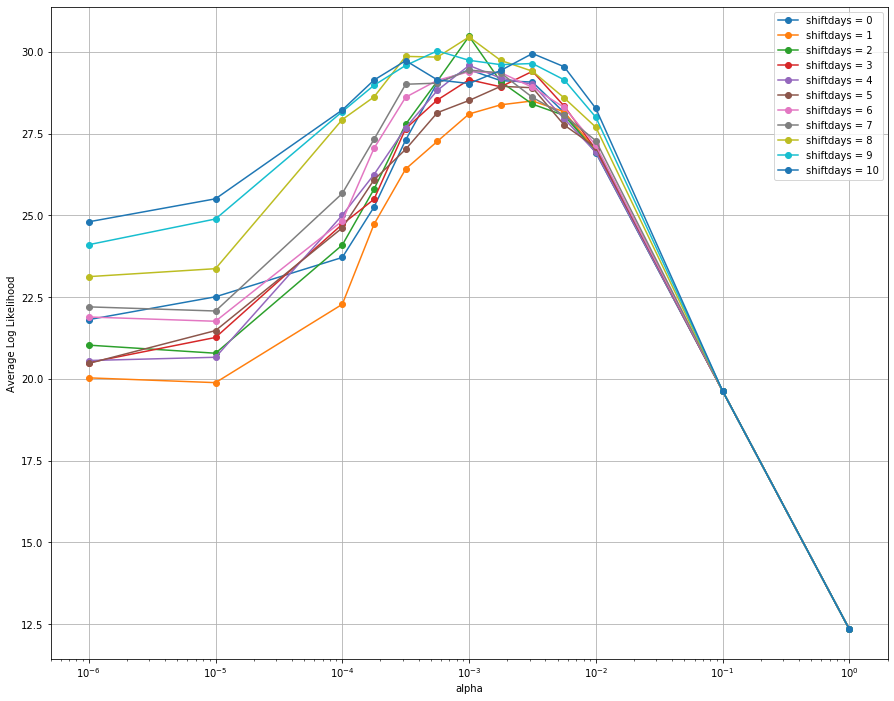

In [60]:
#print(llres)
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]
#print(len(colornames))

for shiftdays in range(maxshift + 1):
    ll_list = []
    alphalist = llres[llres['shiftdays'] == shiftdays]['alpha'].unique()
    alphalist.sort()
    for alpha in alphalist:
        ll_list.append(np.mean(llres[(llres['shiftdays']==shiftdays) & (llres['alpha'] == alpha)]['loglike']))
    plt.plot(alphalist,ll_list, label = 'shiftdays = {}'.format(shiftdays), marker = 'o')
plt.legend()
plt.xscale('log')
plt.xlim([1e-6/2,2e0])
plt.xlabel(r'alpha')
plt.ylabel('Average Log Likelihood')
plt.grid()
plt.show()

In [61]:
model_final = smf.ols(formula = formula, data = regrDF_new[8], drop_cols = 'Time')
results_final = model_final.fit_regularized(alpha = 1e-3, L1_wt = 1)

In [83]:
#print(results_final.predict())

# collect measure names for labels
ml = GetMeasureIDs(measure_level = 2,mincount = 5, extend_measure_names=True)
measure_level_dict = {}
for mn in ml.keys():
    l1,l2 = mn.split(' - ')
    if not l1 in measure_level_dict.keys():
        measure_level_dict[l1] = {}
    measure_level_dict[l1][l2] = CleanUpMeasureName(l2)

intercept = results_final.params['Intercept']

l1list = list(measure_level_dict.keys())
l1list.sort()

for l1 in l1list:
    print(l1)
    l2list = list(measure_level_dict[l1].keys())
    l2list.sort()
    
    for l2 in l2list:
        print('  {:60s} {:6.3f}'.format(l2,results_final.params[measure_level_dict[l1][l2]]/intercept))

#print(intercept)

Case identification, contact tracing and related measures
  Airport health check                                          0.016
  Border health check                                           0.093
  Enhance the system                                            0.066
  Isolation of cases                                            0.000
  Quarantine                                                    0.000
  Research and test of contacts                                 0.000
  Research and test of suspected cases                          0.000
  Specific health channel for travellers                        0.000
  Surveillance                                                 -0.049
  Tracing and monitoring                                        0.000
Healthcare and public health capacity
  Activate emergency response mechanisms                        0.000
  Activate healthcare capacity                                  0.000
  Case management                                              -

In [7]:
# generate regression dicts

maxshift = 10
regrDF40_1 = []
regrDF40_3 = []
regrDF40_5 = []

for shiftdays in np.arange(0,maxshift + 1):
    print(shiftdays)

    tmp,ml = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, maxlen = 40)
    regrDF40_1.append(tmp)

    tmp,ml = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, maxlen = 40, smooth = 3)
    regrDF40_3.append(tmp)
    
    tmp,ml = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, maxlen = 40, smooth = 5)
    regrDF40_5.append(tmp)
    

0
1
2
3
4
5
6
7
8
9
10


In [57]:


# regression and store everything
maxshift = 10

# store all input and output

r2_results       = None
param_results    = None
param_results_nt = None

countrylist = regrDF40_1[0].groupby(by = 'Country').apply(list)

for shiftdays in np.arange(0,maxshift + 1):
    # model formulas
    formula    = 'Observable ~ Time + C(Country) + ' + ' + '.join(ml)
    formula_nt = 'Observable ~ C(Country) + ' + ' + '.join(ml)

    # regression with Ordinary Least Squares (OLS)
    model1    = smf.ols(formula = formula, data = regrDF40_1[shiftdays])
    model3    = smf.ols(formula = formula, data = regrDF40_3[shiftdays])
    model5    = smf.ols(formula = formula, data = regrDF40_5[shiftdays])
    
    model1_nt = smf.ols(formula = formula, data = regrDF40_1[shiftdays], drop_cols = 'Time')
    model3_nt = smf.ols(formula = formula, data = regrDF40_3[shiftdays], drop_cols = 'Time')
    model5_nt = smf.ols(formula = formula, data = regrDF40_5[shiftdays], drop_cols = 'Time')
    
    for alphae in range(-6,-2):
        print(shiftdays,alphae)
        # fit models with and without time
        results1 = model1.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)
        results3 = model3.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)
        results5 = model5.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)

        results1_nt = model1_nt.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)
        results3_nt = model3_nt.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)
        results5_nt = model5_nt.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)
        
        # append prediction results from various models to input DFs
        regrDF40_1[shiftdays]['pred_EN{}'.format(alphae)] = results1.predict()
        regrDF40_3[shiftdays]['pred_EN{}'.format(alphae)] = results3.predict()
        regrDF40_5[shiftdays]['pred_EN{}'.format(alphae)] = results5.predict()
        
        regrDF40_1[shiftdays]['pred_EN_NT{}'.format(alphae)] = results1_nt.predict()
        regrDF40_3[shiftdays]['pred_EN_NT{}'.format(alphae)] = results3_nt.predict()
        regrDF40_5[shiftdays]['pred_EN_NT{}'.format(alphae)] = results5_nt.predict()
        
        
        
        # compute R2 and loglike, append to results DF
        obs_1 = np.array(regrDF40_1[shiftdays]['Observable'])
        obs_3 = np.array(regrDF40_3[shiftdays]['Observable'])
        obs_5 = np.array(regrDF40_5[shiftdays]['Observable'])
        
        r2_1 = 1 - np.sum((obs_1 - results1.predict())**2)/np.sum((obs_1 - np.mean(obs_1))**2)
        r2_3 = 1 - np.sum((obs_3 - results3.predict())**2)/np.sum((obs_3 - np.mean(obs_3))**2)
        r2_5 = 1 - np.sum((obs_5 - results5.predict())**2)/np.sum((obs_5 - np.mean(obs_5))**2)
        
        r2_1_nt = 1 - np.sum((obs_1 - results1_nt.predict())**2)/np.sum((obs_1 - np.mean(obs_1))**2)
        r2_3_nt = 1 - np.sum((obs_3 - results3_nt.predict())**2)/np.sum((obs_3 - np.mean(obs_3))**2)
        r2_5_nt = 1 - np.sum((obs_5 - results5_nt.predict())**2)/np.sum((obs_5 - np.mean(obs_5))**2)
        
        ll1 = model1.loglike(results1.params)
        ll3 = model3.loglike(results3.params)
        ll5 = model5.loglike(results5.params)
        
        ll1_nt = model1_nt.loglike(results1_nt.params)
        ll3_nt = model3_nt.loglike(results3_nt.params)
        ll5_nt = model5_nt.loglike(results5_nt.params)
        
        cur_res_1 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 1, 'Time':True, 'r2':r2_1, 'loglike': ll1}
        cur_res_3 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 3, 'Time':True, 'r2':r2_3, 'loglike': ll3}
        cur_res_5 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 5, 'Time':True, 'r2':r2_5, 'loglike': ll5}

        if r2_results is None:
            r2_results = pd.DataFrame({k:np.array([v]) for k,v in cur_res_1.items()})
        else:
            r2_results = r2_results.append(cur_res_1, ignore_index = True)
        r2_results = r2_results.append(cur_res_3, ignore_index = True)
        r2_results = r2_results.append(cur_res_5, ignore_index = True)

        cur_res_1 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 1, 'Time':False, 'r2':r2_1, 'loglike': ll1_nt}
        cur_res_3 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 3, 'Time':False, 'r2':r2_3, 'loglike': ll3_nt}
        cur_res_5 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 5, 'Time':False, 'r2':r2_5, 'loglike': ll5_nt}
        
        r2_results = r2_results.append(cur_res_1, ignore_index = True)
        r2_results = r2_results.append(cur_res_3, ignore_index = True)
        r2_results = r2_results.append(cur_res_5, ignore_index = True)
        
        
        # store parameters from fit in DFs
        cur_params_1 = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 1, 'param':list(results1.params.index),'value':np.array(results1.params)}
        cur_params_3 = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 3, 'param':list(results3.params.index),'value':np.array(results3.params)}
        cur_params_5 = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 5, 'param':list(results5.params.index),'value':np.array(results5.params)}

        cur_params_1_nt = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 1, 'param':list(results1_nt.params.index),'value':np.array(results1_nt.params)}
        cur_params_3_nt = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 3, 'param':list(results3_nt.params.index),'value':np.array(results3_nt.params)}
        cur_params_5_nt = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 5, 'param':list(results5_nt.params.index),'value':np.array(results5_nt.params)}
        
        if param_results is None:
            param_results = pd.DataFrame({k:np.array(v) for k,v in cur_params_1.items()})
        else:
            param_results.append(cur_params_1, ignore_index = True)
        param_results.append(cur_params_3, ignore_index = True)
        param_results.append(cur_params_5, ignore_index = True)

        if param_results_nt is None:
            param_results_nt = pd.DataFrame({k:np.array(v) for k,v in cur_params_1_nt.items()})
        else:
            param_results_nt.append(cur_params_1_nt, ignore_index = True)
        param_results_nt.append(cur_params_3_nt, ignore_index = True)
        param_results_nt.append(cur_params_5_nt, ignore_index = True)

        
    #print(results.params)
    #print(results.llf)
    #results.save(fname = 'output_{}.txt'.format(shiftdays))
    # output

    # print(results.summary())
    
    #filename = 'regression_shiftdays{}_glm.csv'.format(shiftdays)

    #def dropheaderlines(csv_string, droplines = 10):
    #    return '\n'.join(csv_string.split('\n')[droplines:]),'\n'.join(csv_string.split('\n')[:droplines])

    #csv_table = results.summary().as_csv()

    #fp = open(filename,'w')
    #csv_data, glm_header= dropheaderlines(csv_table)
    #fp.write(csv_data)
    #fp.close()

    #readdata = pd.read_csv(filename)
    #print('shiftdays = {}'.format(shiftdays))
    #print(readdata[readdata['P>|z| '] < 0.05].sort_values(by = 'P>|z| ')[['                                               ', '   coef   ','P>|z| ']])
    #print()
    
    #input_df_glm.append(regrDF)
    #summary_df_glm.append(readdata)
    #measures_glm.append(ml)
    #header_glm.append(glm_header)
#print(r2_results40_5)

0 -6
0 -5
0 -4
0 -3
1 -6
1 -5
1 -4
1 -3
2 -6
2 -5
2 -4
2 -3
3 -6
3 -5
3 -4
3 -3
4 -6
4 -5
4 -4
4 -3
5 -6
5 -5
5 -4
5 -3
6 -6
6 -5
6 -4
6 -3
7 -6
7 -5
7 -4
7 -3
8 -6
8 -5
8 -4
8 -3
9 -6
9 -5
9 -4
9 -3
10 -6
10 -5
10 -4
10 -3


[0.2949532  0.28590835 0.28590835 0.28590835 0.28590835 0.28285382
 0.31165798 0.31165798 0.31165798 0.33496051 0.34573756 0.34573756
 0.28155624 0.27900855 0.23398717 0.23398717 0.23398717 0.23398717
 0.23398717 0.08652922 0.07693429 0.06936302 0.06936302 0.06936302
 0.06936302 0.06936302 0.06936302 0.06936302 0.06936302 0.06936302
 0.06936302 0.06936302 0.03106067 0.03106067]
[0.27922427 0.27922427 0.27922427 0.27922427 0.28440089 0.28440089
 0.28440089 0.32521595 0.32521595 0.32521595 0.32521595 0.32521595
 0.30046743 0.26951722 0.26194595 0.26194595 0.26194595 0.26454033
 0.26454033 0.22623797 0.22369028 0.23319531 0.23763408 0.26643824
 0.22141686 0.1204574  0.1204574  0.1204574  0.1204574  0.09460353
 0.08329555 0.08329555 0.08329555 0.08329555 0.08329555 0.08329555
 0.08329555 0.08329555 0.08329555]
[0.38874778 0.38874778 0.38874778 0.38874778 0.38874778 0.38874778
 0.29306317 0.29306317 0.29306317 0.29306317 0.29306317 0.29306317
 0.29306317 0.29306317 0.29306317 0.28902    0.2

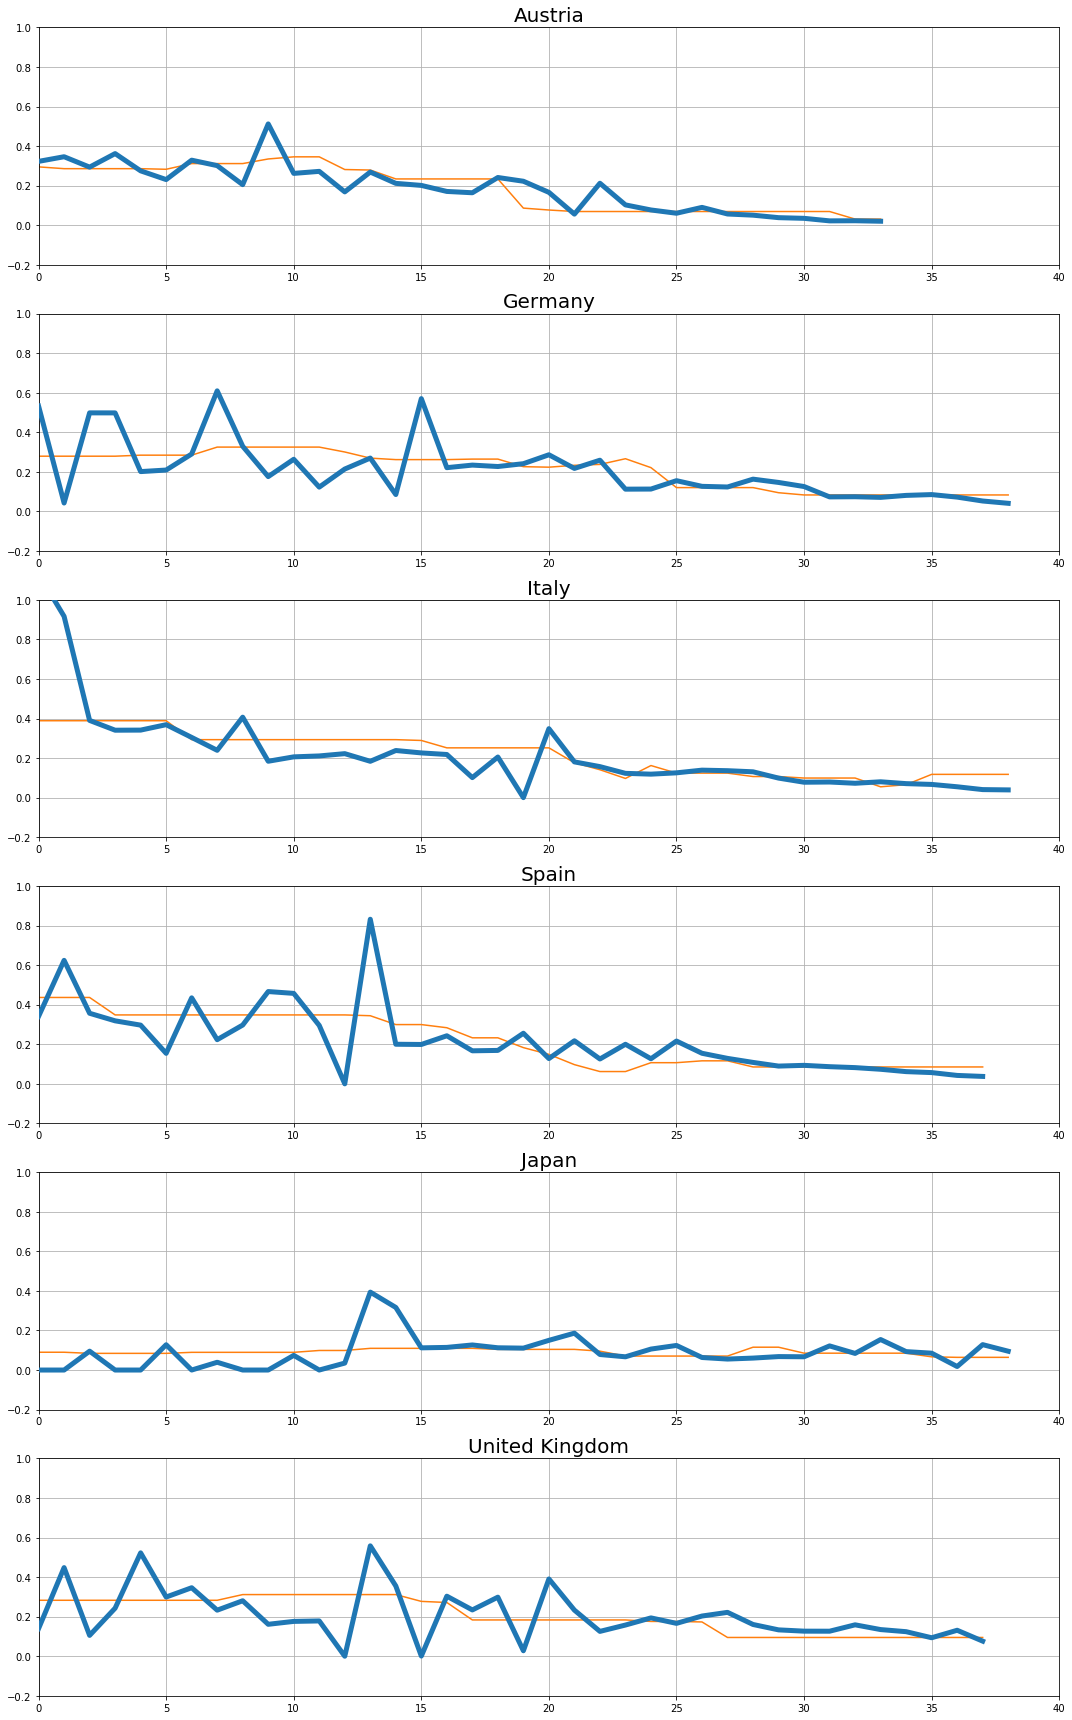

In [58]:
specialcountries = ['Austria','Germany', 'Italy', 'Spain', 'Japan', 'United Kingdom']
cm               = GetCountryMasks(regrDF40_1[0])

fig,ax = plt.subplots(len(specialcountries),1,figsize = (15,4 * len(specialcountries)))

for i,country in enumerate(specialcountries):
    countryobs1 = np.array(regrDF40_1[0]['Observable'][cm[country]])
    #countryobs3 = np.array(regrDF40_3[0]['Observable'][cm[country]])
    #countryobs5 = np.array(regrDF40_5[0]['Observable'][cm[country]])
    ax[i].plot(countryobs1, label = 'Observation', lw = 5, zorder = 100)
    #ax[i].plot(countryobs3, label = 'Observation', lw = 5, zorder = 100)
    #ax[i].plot(countryobs5, label = 'Observation', lw = 5, zorder = 100)
    pred = np.array([regrDF40_1[6]['pred_EN_NT-5'][cm[country]]])[0]
    ax[i].plot(pred,label = 'pred')
    print(pred)
    #for shiftdays in np.arange(maxshift+1):
    #    for alphae in range(-6,3):
    #        curpred1 = np.array(regrDF40_1[shiftdays]['pred_EN{}'.format(alphae)][cm[country]])
    #        curpred3 = np.array(regrDF40_3[shiftdays]['pred_EN{}'.format(alphae)][cm[country]])
    #        curpred5 = np.array(regrDF40_5[shiftdays]['pred_EN{}'.format(alphae)][cm[country]])
    #        ax[i].plot(curpred1, zorder = 20 + alphae)
    #        ax[i].plot(curpred3, zorder = 20 + alphae)
    #        ax[i].plot(curpred5, zorder = 20 + alphae)
    ax[i].set_title(country, fontsize = 20)
    ax[i].set_ylim([-.2,1])
    ax[i].set_xlim([0,40])
    ax[i].grid()
fig.tight_layout()


     shiftdays  alphae  smooth   Time        r2     loglike
0            0      -6       1   True  0.415157  966.429715
1            0      -6       3   True  0.478423  631.110244
2            0      -6       5   True  0.582179  730.689769
3            0      -6       1  False  0.415157  931.458822
4            0      -6       3  False  0.478423  539.683558
..         ...     ...     ...    ...       ...         ...
259         10      -3       3   True  0.410514  554.308346
260         10      -3       5   True  0.525531  650.907474
261         10      -3       1  False  0.278186  828.552471
262         10      -3       3  False  0.410514  500.642146
263         10      -3       5  False  0.525531  559.908936

[264 rows x 6 columns]


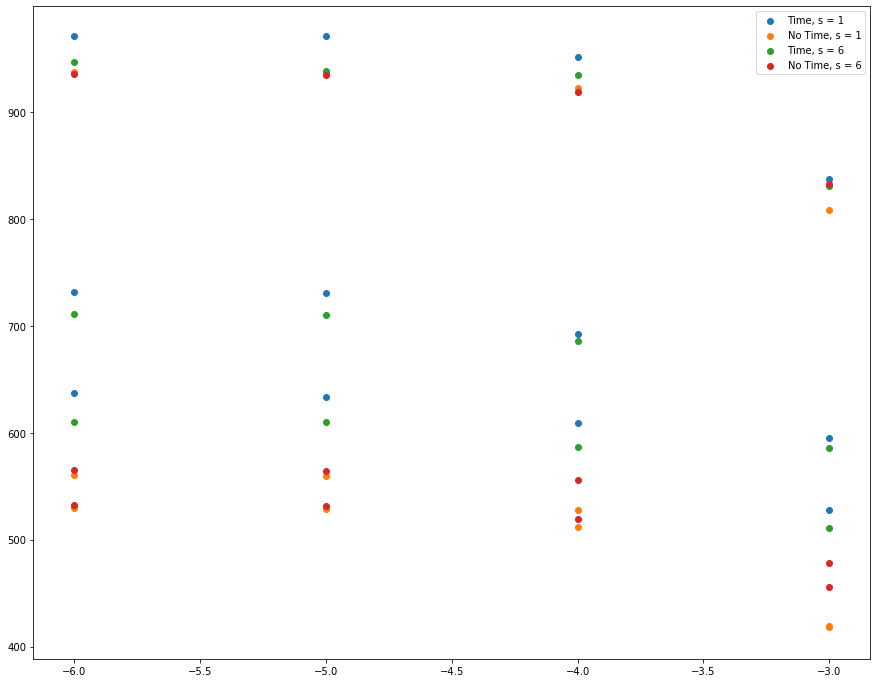

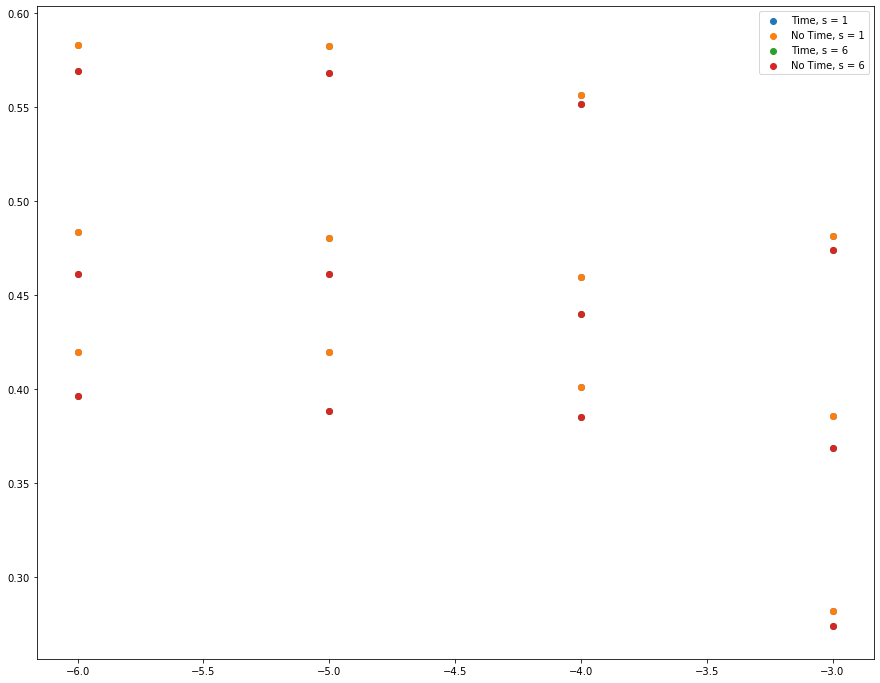

     shiftdays  alphae  smooth   Time        r2     loglike
24           1      -6       1   True  0.419630  971.247223
30           1      -5       1   True  0.419571  971.182642
0            0      -6       1   True  0.415157  966.429715
6            0      -5       1   True  0.413566  964.724625
48           2      -6       1   True  0.411273  962.275385
54           2      -5       1   True  0.410517  961.469954
36           1      -4       1   True  0.401021  951.442717
12           0      -4       1   True  0.396617  946.846025
144          6      -6       1   True  0.396552  946.778019
72           3      -6       1   True  0.395771  945.966324
78           3      -5       1   True  0.394650  944.803807
60           2      -4       1   True  0.392534  942.613619
120          5      -6       1   True  0.390924  940.952912
126          5      -5       1   True  0.389420  939.405740
150          6      -5       1   True  0.388565  938.527554
33           1      -5       1  False  0

In [59]:
print(r2_results)

rt = r2_results[r2_results['Time']]
rnt = r2_results[r2_results['Time'] == False]

rt1 = rt[rt['shiftdays'] == 1]
rt6 = rt[rt['shiftdays'] == 6]
rnt1 = rnt[rnt['shiftdays'] == 1]
rnt6 = rnt[rnt['shiftdays'] == 6]

plt.scatter(rt1['alphae'],rt1['loglike'],label = 'Time, s = 1')
plt.scatter(rnt1['alphae'],rnt1['loglike'], label = 'No Time, s = 1')
plt.scatter(rt6['alphae'],rt6['loglike'],label = 'Time, s = 6')
plt.scatter(rnt6['alphae'],rnt6['loglike'], label = 'No Time, s = 6')
plt.legend()
#plt.ylim([900,1000])
plt.show()

plt.scatter(rt1['alphae'],rt1['r2'],label = 'Time, s = 1')
plt.scatter(rnt1['alphae'],rnt1['r2'], label = 'No Time, s = 1')
plt.scatter(rt6['alphae'],rt6['r2'],label = 'Time, s = 6')
plt.scatter(rnt6['alphae'],rnt6['r2'], label = 'No Time, s = 6')
plt.legend()
#plt.ylim([900,1000])
plt.show()

print(r2_results.sort_values('loglike')[::-1].head(60))

print(param_results_nt)

In [86]:
param_results_nt.sort_values('value')[::-1].head(20)
#print(p.argmax('value'))



for v in param_results_nt.sort_values('value')[::-1].iterrows():
    if not v[1][3][:3] == 'C(C':
        print('{:50s} {:14.6f}'.format(v[1][3],v[1][4]))

Intercept                                                0.281291
SettingPriceForSpecificProtectiveProducts                0.105174
ScaleUpHealthcareCapacity                                0.096927
ActivateHealthcareCapacity                               0.078762
WorkSafetyProtocols                                      0.069063
AirportsClosingForAllInternationalFlights                0.059433
CancellationOfInternationalFlights                       0.055896
NonessentialTravelsForbidden                             0.045585
SpecificHealthChannelForTravellers                       0.042218
SmallGatheringCancellation                               0.041282
ReturnOperationOfNationalsLivingInRegionsAtRisk          0.033485
IsolationOfCases                                         0.032051
CrisisManagementPlans                                    0.031798
SpecialMeasuresForCertainEstablishments                  0.031276
Quarantine                                               0.031251
Research  

In [110]:
model_tmp = smf.ols(formula = formula, data = regrDF40_1[6], drop_cols = 'Time')
results_tmp = model_tmp.fit_regularized(alpha = 1e-6, L1_wt = 1)


#print(results_tmp.params)
k = list(results_tmp.params.keys())
b = np.array(results_tmp.params)

rdf = pd.DataFrame({'param':k,'value':b})
intercept = float(rdf[rdf['param'] == 'Intercept']['value'])
print(intercept)
for v in rdf.sort_values('value')[::-1].iterrows():
    if not v[1][0][:3] == 'C(C':
        print('{:50s} {:14.6f}'.format(v[1][0],v[1][1]/intercept))

#for v in results_tmp.sort_values('value')[::-1].iterrows():
#    print(v)


0.2722378228931533
Intercept                                                1.000000
SpecialMeasuresForCertainEstablishments                  0.293328
EnvironmentalCleaningAndDisinfection                     0.222062
AirportRestriction                                       0.212915
ActivateHealthcareCapacity                               0.199620
StopPublicTransports                                     0.192147
Research                                                 0.151787
AirportHealthCheck                                       0.121793
AirportsClosingForAllInternationalFlights                0.104062
ScaleUpHealthcareCapacity                                0.102065
BorderHealthCheck                                        0.087902
ReturnOperationOfNationalsLivingInRegionsAtRisk          0.065012
TracingAndMonitoring                                     0.055235
NonessentialTravelsForbidden                             0.054667
EncourageSelfinitiatedQuarantine                         

In [9]:
maxshift = 10
regrDF_new = []
model_excludeC = []
model_singleC  = []
llres = None

print(measure_data.countrylist)
for shiftdays in range(0, maxshift + 1):
    print('shiftdays = {}'.format(shiftdays))
    tmp,measurelist_new = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, maxlen = 40, smooth = True, verbose = True)
    print(tmp)
    regrDF_new.append(tmp)

    countrylist = tmp['Country'].unique()
    formula     = 'Observable ~ C(Country) + ' + ' + '.join(measurelist_new)
    
    model_excludeC.append(dict())
    model_singleC.append(dict())
    
    for country in countrylist:
        DF_excludeC = regrDF_new[shiftdays][regrDF_new[shiftdays]['Country'] != country]
        DF_singleC  = regrDF_new[shiftdays][regrDF_new[shiftdays]['Country'] == country]
        model_excludeC[shiftdays][country] = smf.ols(formula = formula, data = DF_excludeC, drop_cols = 'Time')
        model_singleC [shiftdays][country] = smf.ols(formula = formula, data = DF_singleC,  drop_cols = 'Time')
    


['Albania', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Canada', 'Croatia', 'Czech Republic', 'Denmark', 'Diamond Princess', 'Ecuador', 'Estonia', 'Finland', 'France (metropole)', 'Germany', 'Hong Kong', 'Iceland', 'Indonesia', 'Italy', 'Kuwait', 'Liechtenstein', 'Lithuania', 'Malaysia', 'Mexico', 'Montenegro', 'Netherlands', 'Norway', 'Portugal', 'Republic of Ireland', 'Romania', 'Serbia', 'Singapore', 'Slovakia', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Syria', 'Taiwan', 'Thailand', 'United Kingdom', 'New Zealand', 'Japan', 'Honduras', 'El Salvador ', 'Kazakhstan', 'Greece', 'North Macedonia', 'Kosovo', 'Brazil', 'India', 'Hungary']
shiftdays = 0


/home/lukas/projects/corona/programs/measureclass.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countrydata['Measure_L{:d}'.format(ml)] = countrydata['Measure_L{:d}'.format(ml)].fillna(countrydata['Measure_L{:d}'.format(ml-1)])
/home/lukas/projects/corona/programs/measureclass.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countrydata['MN'] = countrydata['Measure_L{:d}'.format(measure_level)]


{'Border restriction': 41, 'Cancellation of international flights': 19, 'Closure of educational institutions': 49, 'Curfew': 10, 'Educate and actively communicate with the public': 48, 'Encourage self-initiated quarantine': 20, 'Enhance healthcare capacity': 40, 'Enhance the system': 26, 'Individual movement restrictions': 21, 'Mass gathering cancellation': 49, 'National lockdown': 11, 'Scale up emergency response mechanisms': 21, 'Specific health channel for travellers': 12, 'Stop public transports': 9, 'Activate emergency response mechanisms': 38, 'Actively communicate with healthcare professionals': 20, 'Actively communicate with stakeholders': 15, 'Airport health check': 23, 'Airport restriction': 19, 'Border health check': 21, 'Call for return of nationals living abroad': 11, 'Cordon sanitaire': 14, 'Crisis management plans': 28, 'Enhance emergency response mechanisms': 22, 'Enhance laboratory testing': 31, 'Isolation of cases': 17, 'Measures for special populations': 33, 'Return 

/usr/lib64/python3.7/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


TypeError: 'NoneType' object is not subscriptable

In [140]:
# prepare all models and do crossvalidation by deleting each country

#countrylist = regrDF_new[0]['Country'].unique()
#formula     = 'Observable ~ C(Country) + ' + ' + '.join(measurelist_new)

print(countrylist)

# crossvalidation
#model_excludeC = []
#model_singleC  = []
#llres = None

for shiftdays in np.arange(maxshift + 1):
    
    print('shiftdays = {}'.format(shiftdays))
    
    for alpha in np.power(10,np.linspace(-6, 0, num = 7)):
        print('  {:.6f}'.format(alpha))
        loglike_list = []
        for country in countrylist:
            results = model_excludeC[shiftdays][country].fit_regularized(alpha = alpha, L1_wt = 1)
            param_excludeC = np.array(results.params)
            param_singleC  = np.concatenate([np.array([param_excludeC[0]]),param_excludeC[len(countrylist)-1:]])
            loglike_list.append(model_singleC[shiftdays][country].loglike(param_singleC))
            
        if llres is None:
            llres = pd.DataFrame({ 'shiftdays': shiftdays * np.ones(len(countrylist), dtype = np.int),
                                   'alpha':     alpha     * np.ones(len(countrylist), dtype = np.int),
                                   'loglike':   np.array(loglike_list)})
        else:
            llres.append(        { 'shiftdays': shiftdays * np.ones(len(countrylist), dtype = np.int),
                                   'alpha':     alpha     * np.ones(len(countrylist), dtype = np.int),
                                   'loglike':   np.array(loglike_list)}, ignore_index = True)


['Albania' 'Austria' 'Belgium' 'Bosnia and Herzegovina' 'Canada' 'Croatia'
 'Denmark' 'Diamond Princess' 'Ecuador' 'Estonia' 'Finland' 'Germany'
 'Iceland' 'Indonesia' 'Italy' 'Kuwait' 'Liechtenstein' 'Lithuania'
 'Malaysia' 'Mexico' 'Montenegro' 'Netherlands' 'Norway' 'Portugal'
 'Romania' 'Serbia' 'Singapore' 'Slovakia' 'Spain' 'Sweden' 'Switzerland'
 'Thailand' 'United Kingdom' 'New Zealand' 'Japan' 'Honduras' 'Kazakhstan'
 'Greece' 'North Macedonia' 'Kosovo' 'Brazil' 'India' 'Hungary']
shiftdays = 0
  0.000001


KeyboardInterrupt: 

In [141]:
print(llres)

for shiftdays in range(maxshift + 1):
    curve = llres[llres['shiftdays'] == shiftdays].groupby(by = 'alpha').apply(np.mean)
    print(curve)

None


TypeError: 'NoneType' object is not subscriptable

In [ ]:

# regression and store everything
maxshift = 10

# store all input and output

r2_results     = None
param_results  = None

for shiftdays in np.arange(0,maxshift + 1):
    # generate all data into pandas DF for regression
    # regrDF,ml = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays)

    # model formula
    formula = 'Observable ~ C(Country) + ' + ' + '.join(ml)

    # regression with Ordinary Least Squares (OLS)
    model1   = smf.ols(formula = formula, data = regrDF40_1[shiftdays])
    model3   = smf.ols(formula = formula, data = regrDF40_3[shiftdays])
    model5   = smf.ols(formula = formula, data = regrDF40_5[shiftdays])
    
    for alphae in range(-6,3):
        print(shiftdays,alphae)

        results1 = model1.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)
        results3 = model3.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)
        results5 = model5.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)

        regrDF40_1[shiftdays]['pred_EN{}'.format(alphae)] = results1.predict()
        regrDF40_3[shiftdays]['pred_EN{}'.format(alphae)] = results3.predict()
        regrDF40_5[shiftdays]['pred_EN{}'.format(alphae)] = results5.predict()
        
        obs_1 = np.array(regrDF40_1[shiftdays]['Observable'])
        obs_3 = np.array(regrDF40_3[shiftdays]['Observable'])
        obs_5 = np.array(regrDF40_5[shiftdays]['Observable'])
        
        r2_1 = 1 - np.sum((obs_1 - results1.predict())**2)/np.sum((obs_1 - np.mean(obs_1))**2)
        r2_3 = 1 - np.sum((obs_3 - results3.predict())**2)/np.sum((obs_3 - np.mean(obs_3))**2)
        r2_5 = 1 - np.sum((obs_5 - results5.predict())**2)/np.sum((obs_5 - np.mean(obs_5))**2)
        
        cur_res_1 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 1,'r2':r2_1}
        cur_res_3 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 3,'r2':r2_3}
        cur_res_5 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 5,'r2':r2_5}

        if r2_results is None:
            r2_results = pd.DataFrame({k:np.array([v]) for k,v in cur_res_1.items()})
        else:
            r2_results = r2_results.append(cur_res_1, ignore_index = True)
        r2_results = r2_results.append(cur_res_3, ignore_index = True)
        r2_results = r2_results.append(cur_res_5, ignore_index = True)

        cur_params_1 = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 1, 'params':results1.params}
        cur_params_3 = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 1, 'params':results3.params}
        cur_params_5 = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 1, 'params':results5.params}
        
        if param_results is None:
            param_results = pd.DataFrame({k:np.array(v) for k,v in cur_params_1.items()})
        else:
            param_results.append(cur_params_1, ignore_index = True)
        param_results.append(cur_params_3, ignore_index = True)
        param_results.append(cur_params_3, ignore_index = True)



In [83]:
o1 = np.array(regrDF40_1[0]['Observable'])
o3 = np.array(regrDF40_3[0]['Observable'])
o5 = np.array(regrDF40_5[0]['Observable'])

print(0.25*(o1[1:-3] + 2*o1[2:-2] + o1[3:-1]))
print(o3[2:-2])
#print(o5)

#plt.plot(o1)
#plt.plot(o3)
#plt.plot(o5)

TypeError: 'NoneType' object is not subscriptable

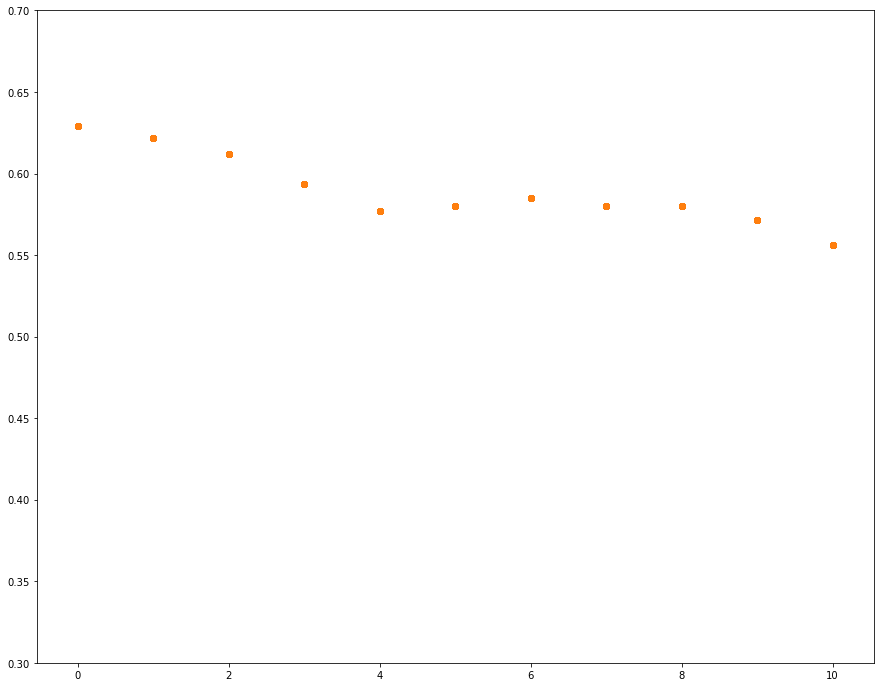

In [59]:
plt.scatter(r2_results['shiftdays'],r2_results['r2'])
plt.scatter(r2_results40_5['shiftdays'],r2_results40_5['r2'])
plt.ylim([.3,.7])
plt.show()

['Albania' 'Austria' 'Belgium' 'Bosnia and Herzegovina' 'Canada' 'Croatia'
 'Denmark' 'Diamond Princess' 'Ecuador' 'Estonia' 'Finland' 'Germany'
 'Iceland' 'Indonesia' 'Italy' 'Kuwait' 'Liechtenstein' 'Lithuania'
 'Malaysia' 'Mexico' 'Montenegro' 'Netherlands' 'Norway' 'Portugal'
 'Romania' 'Serbia' 'Singapore' 'Slovakia' 'Spain' 'Sweden' 'Switzerland'
 'Thailand' 'United Kingdom' 'New Zealand' 'Japan' 'Honduras' 'Kazakhstan'
 'Greece' 'North Macedonia' 'Kosovo' 'Brazil' 'India' 'Hungary']


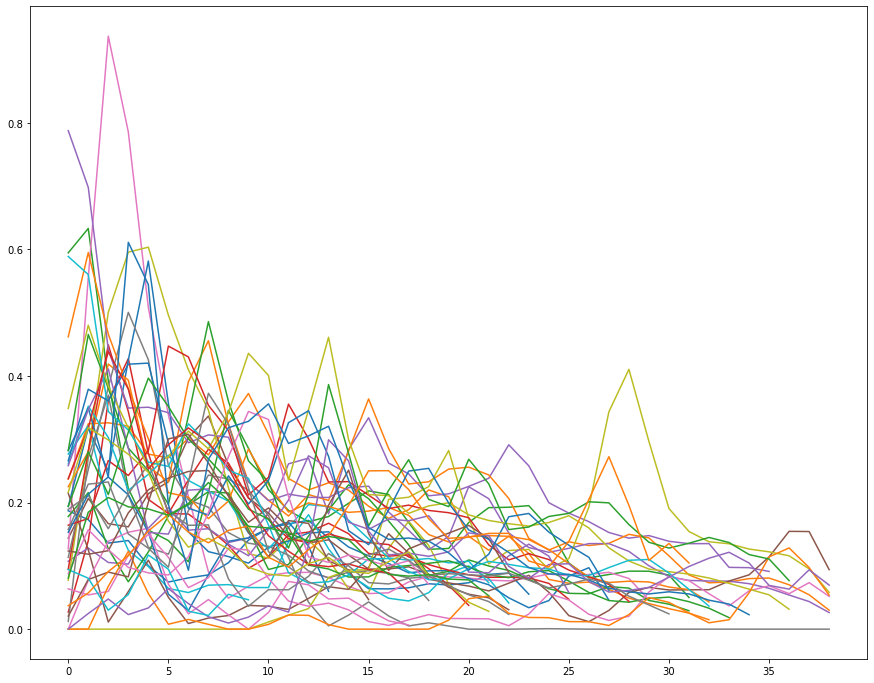

In [62]:
allcountries = regrDF[0]['Country'].unique()
print(allcountries)

for country in allcountries:
    plt.plot(regrDF30[0]['Observable'][cm[country]])
plt.show()


In [ ]:
# graphical output

def getPvalue(shiftdays = 0, country = None, key = None, measure = None):
    if not country is None:
        dfkey = '{:47s}'.format('C(Country)[T.' + country + ']')
    elif not key is None:
        dfkey = '{:47s}'.format(key)
    elif not measure is None:
        dfkey = '{:47s}'.format(measure)
    plist = summary_df_glm[shiftdays][summary_df_glm[shiftdays]['{:47s}'.format('')] == dfkey]['P>|z| ']
    return np.float(plist)
            
def p2color(p):
    if p < 0.05:
        return 'black'
    else:
        return 'lightgray'

# collect measure names for labels
ml = GetMeasureIDs(measure_level = 2,mincount = 5, extend_measure_names=True)
measure_level_dict = {}
for mn in ml.keys():
    l1,l2 = mn.split(' - ')
    if not l1 in measure_level_dict.keys():
        measure_level_dict[l1] = {}
    measure_level_dict[l1][l2] = CleanUpMeasureName(l2)

# collect all countries
countrylist = [name[13:].split(']')[0] for name in summary_df_glm[0]['                                               '] if name[:4] == 'C(Co']

# start plotting
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]
fig,ax = plt.subplots(figsize = (20,30))

label_x      = 1
label_dy     = 1
label_yshift = -.15
plot_x       = 8
plot_dx      = 1

pointsize    = 120
boxalpha     = .08
maxshift     = 10


for shiftdays in np.arange(maxshift + 1):
    groupcolor = 0
    # plot intercept and time effects
    if shiftdays == 0:
        ax.annotate('Intercept', (label_x,     1 * label_dy + label_yshift), c = colornames[groupcolor])
        ax.annotate('Time',      (label_x,     2 * label_dy + label_yshift), c = colornames[groupcolor])
        ax.annotate('Linear Fit',(label_x -.2, 3 * label_dy + label_yshift), c = colornames[groupcolor], weight = 'bold')
        
        background = plt.Rectangle([label_x - .5, .35], plot_x + maxshift + 1 - label_x, 3 + .8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
        ax.add_patch(background)
    
    pval_intercept = getPvalue(shiftdays, key = 'Intercept')
    pval_time      = getPvalue(shiftdays, key = 'Time')
    
    ax.scatter([plot_x + shiftdays],[1 * label_dy], c = p2color(pval_intercept), s = pointsize)
    ax.scatter([plot_x + shiftdays],[2 * label_dy], c = p2color(pval_time),      s = pointsize)
    
    
    # plot country effects
    groupcolor = 1
    i = 5
    if shiftdays == 0:
        background = plt.Rectangle([label_x - .5, i - .65], plot_x + maxshift + 1 - label_x, len(countrylist) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
        ax.add_patch(background)
        ax.annotate('Effects within individual countries', [label_x - .2, i * label_dy + len(countrylist)], c = colornames[groupcolor], weight = 'bold')
        
    for country in countrylist[::-1]:
        if shiftdays == 0:
            ax.annotate(country, (label_x, i * label_dy + label_yshift), c = colornames[groupcolor])
        
        pval_country = getPvalue(shiftdays, country = country)
        ax.scatter([plot_x + shiftdays],[i * label_dy], c = p2color(pval_country), s = pointsize)
        
        
        i += 1
    
    
    l1keys = list(measure_level_dict.keys())
    l1keys.sort()
    
    # plot measures effects
    for l1key in l1keys[::-1]:
        groupcolor += 1
        i += 2
        l2keys = list(measure_level_dict[l1key].keys())
        l2keys.sort()
        
        if shiftdays == 0:
            background = plt.Rectangle([label_x - .5, i - .65], plot_x + maxshift + 1 - label_x, len(measure_level_dict[l1key]) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
            ax.add_patch(background)
            ax.annotate(l1key, [label_x - .2, (i + len(measure_level_dict[l1key]))*label_dy + label_yshift], c = colornames[groupcolor], weight = 'bold')
            
        for l2key in l2keys[::-1]:
            if shiftdays == 0:
                count_countries = measures_glm[shiftdays][measure_level_dict[l1key][l2key]]
                active_days = np.array(input_df_glm[shiftdays][measure_level_dict[l1key][l2key]])
                fraction_active =  np.sum(active_days)/len(active_days)
                ax.annotate('{}'.format(l2key),[label_x, i*label_dy + label_yshift], c = colornames[groupcolor])
                ax.annotate('{:d}'.format(count_countries) ,[plot_x - 1.8, i*label_dy + label_yshift], c = colornames[groupcolor])
                ax.annotate('{:.4f}'.format(fraction_active),[plot_x - 1, i*label_dy + label_yshift], c = colornames[groupcolor])
            pval_measure = getPvalue(shiftdays, measure = measure_level_dict[l1key][l2key])
            ax.scatter([plot_x + shiftdays],[i * label_dy], c = p2color(pval_measure), s = pointsize)
            i += 1
    ax.axes.set_xlim([0,18])
    ax.annotate('{}'.format(shiftdays),[plot_x + shiftdays,(i+2)*label_dy + label_yshift])

ax.annotate('Shift Effects by Days:', [label_x, (i+2) * label_dy + label_yshift])
ax.axis('off')
#fig.show()
plt.savefig('regression_measures_glm.pdf')

In [ ]:
print(countrylist)